# Project 2: Linear Regression Price Predictor for Used Cars

In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, ElasticNet, ElasticNetCV

import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style('whitegrid')

### Section 1: DataFrame Loading, Cleaning

In [2]:
# Returns you all the variables in the current environment

# dir()  

# Refer to this link: https://stackoverflow.com/questions/633127/viewing-all-defined-variables
# To find out out to view all defined variables in the current environment

In [3]:
df_main = pd.read_csv('sgcarmart_used_cars_prices.csv',index_col=0)
df_main.sample(5)

LISTING_URL       BRAND    PRICE  \
2096  https://www.sgcarmart.com/used_cars/info.php?I...       Mazda  79800.0   
1868  https://www.sgcarmart.com/used_cars/info.php?I...  Volkswagen  63800.0   
3266  https://www.sgcarmart.com/used_cars/info.php?I...      Toyota  93988.0   
2895  https://www.sgcarmart.com/used_cars/info.php?I...       Honda  23888.0   
3555  https://www.sgcarmart.com/used_cars/info.php?I...      Toyota  98800.0   

      DEPRE_VALUE_PER_YEAR     REG_DATE  MILEAGE_KM MANUFACTURED_YEAR  \
2096               10420.0  18-Jan-2016     50200.0              2015   
1868                6370.0  08-Feb-2010         NaN              2009   
3266               11460.0  29-Jul-2016     43000.0              2015   
2895                6230.0  23-Aug-2008         NaN              2008   
3555                9920.0  11-Oct-2017      7000.0              2016   

      ROAD_TAX_PER_YEAR TRANSMISSION  DEREG_VALUE_FROM_SCRAPE_DATE  \
2096             1786.0         Auto                       56442.0   
1868             1194.0         Auto                           NaN   
3266             1196.0         Auto                       63533.0   
2895              649.0         Auto                       13108.0   
3555             1198.0         Auto                       67901.0   

     SCRAPE_DATE      OMV      ARF  COE_FROM_SCRAPE_DATE  DAYS_OF_COE_LEFT  \
2096  23/10/2019  26776.0  29487.0               55001.0            2255.0   
1868  23/10/2019  30323.0  30323.0                   NaN               0.0   
3266  23/10/2019  32730.0  32822.0               57508.0            2465.0   
2895  23/10/2019  11957.0  11957.0               17099.0            1365.0   
3555  23/10/2019  33944.0  39522.0               48005.0            2592.0   

      ENGINE_CAPACITY_CC  CURB_WEIGHT_KG  NO_OF_OWNERS VEHICLE_TYPE  
2096                2488          1568.0           2.0          SUV  
1868                1984          1393.0           2.0   Sports Car  
3266                1986          1610.0           1.0          SUV  
2895                1339          1010.0           5.0    Hatchback  
3555                1987          1565.0           1.0          SUV

In [6]:
df_main.columns

Index(['LISTING_URL', 'BRAND', 'PRICE', 'DEPRE_VALUE_PER_YEAR', 'REG_DATE',
       'MILEAGE_KM', 'MANUFACTURED_YEAR', 'ROAD_TAX_PER_YEAR', 'TRANSMISSION',
       'DEREG_VALUE_FROM_SCRAPE_DATE', 'SCRAPE_DATE', 'OMV', 'ARF',
       'COE_FROM_SCRAPE_DATE', 'DAYS_OF_COE_LEFT', 'ENGINE_CAPACITY_CC',
       'CURB_WEIGHT_KG', 'NO_OF_OWNERS', 'VEHICLE_TYPE'],
      dtype='object')

In [4]:
df_clean = df_main.drop(['LISTING_URL', 'SCRAPE_DATE'],axis=1) # Dropping columns that I used for my own reference

# We see that we have NA entries in this dataset. 
# We want to drop these NA values or they will pose problems for us later
# The null values can be attributed to the fact that some data is not keyed in the listing itself, 
# or formatting issues due to the varying ways of which people organize the information of the car in a single listing

df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3987 entries, 0 to 3986
Data columns (total 17 columns):
BRAND                           3987 non-null object
PRICE                           3962 non-null float64
DEPRE_VALUE_PER_YEAR            3876 non-null float64
REG_DATE                        3987 non-null object
MILEAGE_KM                      3338 non-null float64
MANUFACTURED_YEAR               3987 non-null object
ROAD_TAX_PER_YEAR               3833 non-null float64
TRANSMISSION                    3987 non-null object
DEREG_VALUE_FROM_SCRAPE_DATE    3221 non-null float64
OMV                             3963 non-null float64
ARF                             3957 non-null float64
COE_FROM_SCRAPE_DATE            3236 non-null float64
DAYS_OF_COE_LEFT                3963 non-null float64
ENGINE_CAPACITY_CC              3987 non-null int64
CURB_WEIGHT_KG                  3859 non-null float64
NO_OF_OWNERS                    3925 non-null float64
VEHICLE_TYPE                    398

In [5]:
# We now have 2584 rows of data after dropping null values

df_clean.dropna(inplace=True)
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2584 entries, 3 to 3985
Data columns (total 17 columns):
BRAND                           2584 non-null object
PRICE                           2584 non-null float64
DEPRE_VALUE_PER_YEAR            2584 non-null float64
REG_DATE                        2584 non-null object
MILEAGE_KM                      2584 non-null float64
MANUFACTURED_YEAR               2584 non-null object
ROAD_TAX_PER_YEAR               2584 non-null float64
TRANSMISSION                    2584 non-null object
DEREG_VALUE_FROM_SCRAPE_DATE    2584 non-null float64
OMV                             2584 non-null float64
ARF                             2584 non-null float64
COE_FROM_SCRAPE_DATE            2584 non-null float64
DAYS_OF_COE_LEFT                2584 non-null float64
ENGINE_CAPACITY_CC              2584 non-null int64
CURB_WEIGHT_KG                  2584 non-null float64
NO_OF_OWNERS                    2584 non-null float64
VEHICLE_TYPE                    258

In [6]:
# Taking a look at our data
df_clean.sample(5)

BRAND     PRICE  DEPRE_VALUE_PER_YEAR     REG_DATE  MILEAGE_KM  \
1343  Mercedes-Benz   90800.0               12120.0  25-Feb-2016     78800.0   
112           Mazda   49800.0                8080.0  19-Aug-2015     73807.0   
1517  Mercedes-Benz   59888.0               12300.0  12-Dec-2013     54000.0   
3400    Lamborghini  358888.0              102940.0  11-Nov-2011     24000.0   
3723            BMW  209888.0               22700.0  28-Feb-2017     25000.0   

     MANUFACTURED_YEAR  ROAD_TAX_PER_YEAR TRANSMISSION  \
1343              2015              740.0         Auto   
112               2015              682.0         Auto   
1517              2013              740.0         Auto   
3400              2011             5834.0         Auto   
3723              2016             1906.0         Auto   

      DEREG_VALUE_FROM_SCRAPE_DATE       OMV       ARF  COE_FROM_SCRAPE_DATE  \
1343                       48095.0   25533.0   27747.0               43000.0   
112                        38325.0   15513.0    5513.0               58700.0   
1517                       42638.0   25714.0   18000.0               72609.0   
3400                      191558.0  295282.0  295282.0               70117.0   
3723                      101989.0   63323.0   85982.0               51000.0   

      DAYS_OF_COE_LEFT  ENGINE_CAPACITY_CC  CURB_WEIGHT_KG  NO_OF_OWNERS  \
1343            2311.0                1595          1470.0           1.0   
112             2101.0                1496          1036.0           1.0   
1517            1498.0                1595          1425.0           2.0   
3400             738.0                5204          1500.0           3.0   
3723            2679.0                1995          2040.0           2.0   

     VEHICLE_TYPE  
1343          SUV  
112     Hatchback  
1517    Hatchback  
3400   Sports Car  
3723          SUV

In [7]:
print(df_clean.columns,'\n',len(df_clean.columns))

# We have 17 features in our columns

Index(['BRAND', 'PRICE', 'DEPRE_VALUE_PER_YEAR', 'REG_DATE', 'MILEAGE_KM',
       'MANUFACTURED_YEAR', 'ROAD_TAX_PER_YEAR', 'TRANSMISSION',
       'DEREG_VALUE_FROM_SCRAPE_DATE', 'OMV', 'ARF', 'COE_FROM_SCRAPE_DATE',
       'DAYS_OF_COE_LEFT', 'ENGINE_CAPACITY_CC', 'CURB_WEIGHT_KG',
       'NO_OF_OWNERS', 'VEHICLE_TYPE'],
      dtype='object') 
 17


### Section 2: Data Categorizing

## Section 2.1: One-hot encoding TRANSMISSION Column

In [8]:
# Here, we see that there only two options for transmission - Auto or Manual (i.e., Auto or not). 
# Therefore, we can do 1-hot encoding for this

df_clean['TRANSMISSION'].value_counts()

Auto      2547
Manual      37
Name: TRANSMISSION, dtype: int64

In [9]:
# Transmission conversion -> 1 for auto, 0 for manual (just 1 column only)

df_clean['TRANSMISSION_CONVERT'] = df_clean['TRANSMISSION'].apply(lambda x: 1 if x == 'Auto' else 0)
df_clean.drop('TRANSMISSION',axis=1,inplace=True)
df_clean.rename(columns={'TRANSMISSION_CONVERT':"TRANSMISSION"}, inplace=True)  # Renaming column back
df_clean.sample(5)

BRAND    PRICE  DEPRE_VALUE_PER_YEAR     REG_DATE  MILEAGE_KM  \
1275     BMW  90800.0               12430.0  28-Dec-2015     66534.0   
370   Nissan  95888.0               11830.0  16-Nov-2016     38770.0   
3       Audi  70800.0               16580.0  05-Dec-2011    140800.0   
2738  Nissan  80500.0                8960.0  11-Dec-2017     40000.0   
749      BMW  24800.0               18150.0  11-Jun-2010     92000.0   

     MANUFACTURED_YEAR  ROAD_TAX_PER_YEAR  DEREG_VALUE_FROM_SCRAPE_DATE  \
1275              2015              684.0                       58049.0   
370               2016             1210.0                       58118.0   
3                 2011             2380.0                       58899.0   
2738              2017              508.0                       49475.0   
749               2010             1208.0                       15784.0   

          OMV      ARF  COE_FROM_SCRAPE_DATE  DAYS_OF_COE_LEFT  \
1275  29235.0  27929.0               60001.0            2254.0   
370   23227.0  24518.0               56206.0            2558.0   
3     71379.0  71379.0               75889.0             761.0   
2738  20143.0  15201.0               46791.0            2957.0   
749   26631.0  26631.0               39002.0             218.0   

      ENGINE_CAPACITY_CC  CURB_WEIGHT_KG  NO_OF_OWNERS  VEHICLE_TYPE  \
1275                1499          1425.0           1.0  Luxury Sedan   
370                 1997          1626.0           1.0           SUV   
3                   2995          2250.0           3.0           SUV   
2738                1197          1325.0           1.0           SUV   
749                 1995          1390.0           4.0  Luxury Sedan   

      TRANSMISSION  
1275             1  
370              1  
3                1  
2738             1  
749              1

In [10]:
# Performing whitespace stripping prior to dtype manipulation
df_clean['VEHICLE_TYPE'].apply(str.strip)
df_clean['VEHICLE_TYPE'].apply(str.lstrip)

# Inspection of the type of Vehicles
df_clean['VEHICLE_TYPE'].value_counts()

Luxury Sedan       557
SUV                555
Mid-Sized Sedan    497
Hatchback          389
MPV                278
Sports Car         261
Stationwagon        47
Name: VEHICLE_TYPE, dtype: int64

In [11]:
df_clean.head()

BRAND    PRICE  DEPRE_VALUE_PER_YEAR     REG_DATE  MILEAGE_KM  \
3           Audi  70800.0               16580.0  05-Dec-2011    140800.0   
4         Toyota  65800.0                6850.0  26-Jun-2009    117000.0   
5  Mercedes-Benz  45000.0               18550.0  21-Sep-2010    126000.0   
7            BMW  70800.0               12680.0  23-Apr-2014     41000.0   
9           Audi  89500.0               11910.0  25-Nov-2015     57784.0   

  MANUFACTURED_YEAR  ROAD_TAX_PER_YEAR  DEREG_VALUE_FROM_SCRAPE_DATE      OMV  \
3              2011             2380.0                       58899.0  71379.0   
4              2009              974.0                       38024.0  23465.0   
5              2010              974.0                       31818.0  56154.0   
7              2013              742.0                       54685.0  32459.0   
9              2015              624.0                       62640.0  29913.0   

       ARF  COE_FROM_SCRAPE_DATE  DAYS_OF_COE_LEFT  ENGINE_CAPACITY_CC  \
3  71379.0               75889.0             761.0                2995   
4  23465.0               39563.0            3503.0                1797   
5  56154.0               41006.0               8.0                1796   
7  27443.0               78810.0            1610.0                1598   
9  33879.0               61103.0            2221.0                1395   

   CURB_WEIGHT_KG  NO_OF_OWNERS  VEHICLE_TYPE  TRANSMISSION  
3          2250.0           3.0           SUV             1  
4          1350.0           2.0           MPV             1  
5          1650.0           4.0  Luxury Sedan             1  
7          1405.0           2.0  Luxury Sedan             1  
9          1480.0           2.0           SUV             1

## Section 2.2: Datetime conversion

In [12]:
# Converting reg_date to datetime, and Manufactured year to int

df_clean['REG_DATE'] = pd.to_datetime(df_clean['REG_DATE'])
df_clean['MANUFACTURED_YEAR'] = df_clean['MANUFACTURED_YEAR'].astype(int)
df_clean[['REG_DATE','MANUFACTURED_YEAR']].dtypes

REG_DATE             datetime64[ns]
MANUFACTURED_YEAR             int32
dtype: object

In [13]:
df_clean.dtypes

BRAND                                   object
PRICE                                  float64
DEPRE_VALUE_PER_YEAR                   float64
REG_DATE                        datetime64[ns]
MILEAGE_KM                             float64
MANUFACTURED_YEAR                        int32
ROAD_TAX_PER_YEAR                      float64
DEREG_VALUE_FROM_SCRAPE_DATE           float64
OMV                                    float64
ARF                                    float64
COE_FROM_SCRAPE_DATE                   float64
DAYS_OF_COE_LEFT                       float64
ENGINE_CAPACITY_CC                       int64
CURB_WEIGHT_KG                         float64
NO_OF_OWNERS                           float64
VEHICLE_TYPE                            object
TRANSMISSION                             int64
dtype: object

In [14]:
# ONLY RUN THIS CELL ONCE!
df_main['SCRAPE_DATE'] = \
pd.to_datetime(df_main['SCRAPE_DATE']).dt.year # Convert scrape date to integer to perform operations on them


In [15]:
df_main['SCRAPE_DATE'] # Checking dtype

0       2019
1       2019
2       2019
3       2019
4       2019
        ... 
3982    2019
3983    2019
3984    2019
3985    2019
3986    2019
Name: SCRAPE_DATE, Length: 3987, dtype: int64

### Section 2.2.1: Adding a Car Age Column

In [16]:
# Converting current scrape date from main dataframe to datetime object using pandas
from datetime import date

# Obtaining number of years from year of manufacture to current year (metric for how new the car is)
df_clean['CAR_AGE'] = df_main['SCRAPE_DATE'] - df_clean['MANUFACTURED_YEAR'] # Obtaining values for age of car
df_clean['CAR_AGE'].astype(int)

3        8
4       10
5        9
7        6
9        4
        ..
3981     3
3982     5
3983     7
3984     2
3985     4
Name: CAR_AGE, Length: 2584, dtype: int32

In [17]:
# Rearranging Columns 
df_clean = df_clean[['BRAND', 'PRICE', 'DEPRE_VALUE_PER_YEAR', 'MILEAGE_KM', 'COE_FROM_SCRAPE_DATE', 'DAYS_OF_COE_LEFT', 
                    'REG_DATE', 'MANUFACTURED_YEAR', 'CAR_AGE', 'DEREG_VALUE_FROM_SCRAPE_DATE', 'OMV', 'ARF', 
                    'ENGINE_CAPACITY_CC', 'ROAD_TAX_PER_YEAR', 'CURB_WEIGHT_KG',
                    'NO_OF_OWNERS', 'VEHICLE_TYPE', 'TRANSMISSION']]
df_clean.head()

BRAND    PRICE  DEPRE_VALUE_PER_YEAR  MILEAGE_KM  \
3           Audi  70800.0               16580.0    140800.0   
4         Toyota  65800.0                6850.0    117000.0   
5  Mercedes-Benz  45000.0               18550.0    126000.0   
7            BMW  70800.0               12680.0     41000.0   
9           Audi  89500.0               11910.0     57784.0   

   COE_FROM_SCRAPE_DATE  DAYS_OF_COE_LEFT   REG_DATE  MANUFACTURED_YEAR  \
3               75889.0             761.0 2011-12-05               2011   
4               39563.0            3503.0 2009-06-26               2009   
5               41006.0               8.0 2010-09-21               2010   
7               78810.0            1610.0 2014-04-23               2013   
9               61103.0            2221.0 2015-11-25               2015   

   CAR_AGE  DEREG_VALUE_FROM_SCRAPE_DATE      OMV      ARF  \
3      8.0                       58899.0  71379.0  71379.0   
4     10.0                       38024.0  23465.0  23465.0   
5      9.0                       31818.0  56154.0  56154.0   
7      6.0                       54685.0  32459.0  27443.0   
9      4.0                       62640.0  29913.0  33879.0   

   ENGINE_CAPACITY_CC  ROAD_TAX_PER_YEAR  CURB_WEIGHT_KG  NO_OF_OWNERS  \
3                2995             2380.0          2250.0           3.0   
4                1797              974.0          1350.0           2.0   
5                1796              974.0          1650.0           4.0   
7                1598              742.0          1405.0           2.0   
9                1395              624.0          1480.0           2.0   

   VEHICLE_TYPE  TRANSMISSION  
3           SUV             1  
4           MPV             1  
5  Luxury Sedan             1  
7  Luxury Sedan             1  
9           SUV             1

## Section 2.3: VEHICLE_TYPE To Dummy Variables

In [18]:
# Making Dummy Variables out of Vehicle Types:

x_vehtype_dummy = patsy.dmatrix('VEHICLE_TYPE',data=df_clean,return_type='dataframe')
x_vehtype_dummy.head()

# Do we drop the "Intercept" column?

Intercept  VEHICLE_TYPE[T.Luxury Sedan]  VEHICLE_TYPE[T.MPV]  \
3        1.0                           0.0                  0.0   
4        1.0                           0.0                  1.0   
5        1.0                           1.0                  0.0   
7        1.0                           1.0                  0.0   
9        1.0                           0.0                  0.0   

   VEHICLE_TYPE[T.Mid-Sized Sedan]  VEHICLE_TYPE[T.SUV]  \
3                              0.0                  1.0   
4                              0.0                  0.0   
5                              0.0                  0.0   
7                              0.0                  0.0   
9                              0.0                  1.0   

   VEHICLE_TYPE[T.Sports Car]  VEHICLE_TYPE[T.Stationwagon]  
3                         0.0                           0.0  
4                         0.0                           0.0  
5                         0.0                           0.0  
7                         0.0                           0.0  
9                         0.0                           0.0

In [19]:
df_clean2 = df_clean.join(x_vehtype_dummy)
df_clean2

BRAND     PRICE  DEPRE_VALUE_PER_YEAR  MILEAGE_KM  \
3              Audi   70800.0               16580.0    140800.0   
4            Toyota   65800.0                6850.0    117000.0   
5     Mercedes-Benz   45000.0               18550.0    126000.0   
7               BMW   70800.0               12680.0     41000.0   
9              Audi   89500.0               11910.0     57784.0   
...             ...       ...                   ...         ...   
3981  Mercedes-Benz  103800.0               13470.0     19000.0   
3982         Toyota  104500.0               16550.0     47638.0   
3983  Mercedes-Benz  115000.0               15260.0     51500.0   
3984           MINI  119800.0               13150.0     16000.0   
3985         Nissan   81800.0                9900.0     53339.0   

      COE_FROM_SCRAPE_DATE  DAYS_OF_COE_LEFT   REG_DATE  MANUFACTURED_YEAR  \
3                  75889.0             761.0 2011-12-05               2011   
4                  39563.0            3503.0 2009-06-26               2009   
5                  41006.0               8.0 2010-09-21               2010   
7                  78810.0            1610.0 2014-04-23               2013   
9                  61103.0            2221.0 2015-11-25               2015   
...                    ...               ...        ...                ...   
3981               53694.0            2434.0 2016-07-18               2016   
3982               84504.0            1679.0 2014-06-02               2014   
3983               67901.0            1950.0 2015-03-11               2012   
3984               53300.0            2769.0 2017-06-07               2017   
3985               57501.0            2462.0 2016-08-05               2015   

      CAR_AGE  DEREG_VALUE_FROM_SCRAPE_DATE  ...  NO_OF_OWNERS  VEHICLE_TYPE  \
3         8.0                       58899.0  ...           3.0           SUV   
4        10.0                       38024.0  ...           2.0           MPV   
5         9.0                       31818.0  ...           4.0  Luxury Sedan   
7         6.0                       54685.0  ...           2.0  Luxury Sedan   
9         4.0                       62640.0  ...           2.0           SUV   
...       ...                           ...  ...           ...           ...   
3981      3.0                       55704.0  ...           1.0  Luxury Sedan   
3982      5.0                       78422.0  ...           2.0           MPV   
3983      7.0                       85824.0  ...           2.0    Sports Car   
3984      2.0                       69888.0  ...           1.0    Sports Car   
3985      4.0                       60983.0  ...           1.0  Luxury Sedan   

      TRANSMISSION  Intercept  VEHICLE_TYPE[T.Luxury Sedan]  \
3                1        1.0                           0.0   
4                1        1.0                           0.0   
5                1        1.0                           1.0   
7                1        1.0                           1.0   
9                1        1.0                           0.0   
...            ...        ...                           ...   
3981             1        1.0                           1.0   
3982             1        1.0                           0.0   
3983             1        1.0                           0.0   
3984             1        1.0                           0.0   
3985             1        1.0                           1.0   

      VEHICLE_TYPE[T.MPV] VEHICLE_TYPE[T.Mid-Sized Sedan]  \
3                     0.0                             0.0   
4                     1.0                             0.0   
5                     0.0                             0.0   
7                     0.0                             0.0   
9                     0.0                             0.0   
...                   ...                             ...   
3981                  0.0                             0.0   
3982                  1.0                             0.0   
3983 

## Section 2.4: Car Brand Categorization. Includes:
* Splitting them into Dummy Variables
* Indexing them into price range categories (perhaps better metric over vehicle types)
* Converting lesser-known brands into "others"

In [20]:
# Renaming Brand Names to their actual names

df_clean2.loc[df_clean2['BRAND'] == 'Aston','BRAND'] = 'Aston Martin'
df_clean2.loc[df_clean2['BRAND'] == 'Land','BRAND'] = 'Land Rover'
df_clean2.loc[df_clean2['BRAND'] == 'Alfa', 'BRAND'] = 'Alfa Romeo'

In [21]:
# Cleaning whitespaces from the values in "Brand" to prevent any messup later
df_clean2['BRAND'].apply(str.strip)

# Checking the number of brands in the dataset
print("# Of rows in DataFrame in Brands Column:\n", df_clean2.loc[:,'BRAND'])
print("\nValue Counts of Brands:\n", df_clean2.loc[:,'BRAND'].value_counts())
print("\n# of Brands:", len(df_clean2.loc[:,'BRAND'].value_counts()))

# New Column ATAS
# New Column Budget Cars
# Top 20 brands
# Am I comfortable with grouping uncommon cars into others?

# Of rows in DataFrame in Brands Column:
 3                Audi
4              Toyota
5       Mercedes-Benz
7                 BMW
9                Audi
            ...      
3981    Mercedes-Benz
3982           Toyota
3983    Mercedes-Benz
3984             MINI
3985           Nissan
Name: BRAND, Length: 2584, dtype: object

Value Counts of Brands:
 Toyota           405
Mercedes-Benz    374
Honda            309
BMW              286
Mazda            139
Nissan           127
Audi             127
Volkswagen       107
Kia               78
Hyundai           77
Volvo             63
Mitsubishi        58
Subaru            56
Porsche           51
Lexus             49
MINI              40
Suzuki            33
Jaguar            22
Citroen           22
Renault           19
Chevrolet         19
Maserati          18
Land Rover        16
Ford              14
Infiniti          14
Peugeot           13
Ferrari           11
Bentley            6
Lamborghini        6
McLaren            5
Opel               

## Section 3: Data Visualization
* EDA  
* Correlation Matrix  
* Pairplots  

## Section 3.1: Preliminary Correlation Exploration

### Section 3.1.1: Analysis without Car Brands and Vehicle Types for Feature Dropping

In [22]:
df_clean2.columns

Index(['BRAND', 'PRICE', 'DEPRE_VALUE_PER_YEAR', 'MILEAGE_KM',
       'COE_FROM_SCRAPE_DATE', 'DAYS_OF_COE_LEFT', 'REG_DATE',
       'MANUFACTURED_YEAR', 'CAR_AGE', 'DEREG_VALUE_FROM_SCRAPE_DATE', 'OMV',
       'ARF', 'ENGINE_CAPACITY_CC', 'ROAD_TAX_PER_YEAR', 'CURB_WEIGHT_KG',
       'NO_OF_OWNERS', 'VEHICLE_TYPE', 'TRANSMISSION', 'Intercept',
       'VEHICLE_TYPE[T.Luxury Sedan]', 'VEHICLE_TYPE[T.MPV]',
       'VEHICLE_TYPE[T.Mid-Sized Sedan]', 'VEHICLE_TYPE[T.SUV]',
       'VEHICLE_TYPE[T.Sports Car]', 'VEHICLE_TYPE[T.Stationwagon]'],
      dtype='object')

In [25]:
df_price_no_brands = df_clean2[['PRICE', 'DEPRE_VALUE_PER_YEAR', 'MILEAGE_KM',
       'COE_FROM_SCRAPE_DATE', 'DAYS_OF_COE_LEFT', 'REG_DATE',
       'MANUFACTURED_YEAR', 'CAR_AGE', 'DEREG_VALUE_FROM_SCRAPE_DATE', 'OMV',
       'ARF', 'ENGINE_CAPACITY_CC', 'ROAD_TAX_PER_YEAR', 'CURB_WEIGHT_KG',
       'NO_OF_OWNERS', 'VEHICLE_TYPE', 'TRANSMISSION']]
df_price_no_brands.head()

PRICE  DEPRE_VALUE_PER_YEAR  MILEAGE_KM  COE_FROM_SCRAPE_DATE  \
3  70800.0               16580.0    140800.0               75889.0   
4  65800.0                6850.0    117000.0               39563.0   
5  45000.0               18550.0    126000.0               41006.0   
7  70800.0               12680.0     41000.0               78810.0   
9  89500.0               11910.0     57784.0               61103.0   

   DAYS_OF_COE_LEFT   REG_DATE  MANUFACTURED_YEAR  CAR_AGE  \
3             761.0 2011-12-05               2011      8.0   
4            3503.0 2009-06-26               2009     10.0   
5               8.0 2010-09-21               2010      9.0   
7            1610.0 2014-04-23               2013      6.0   
9            2221.0 2015-11-25               2015      4.0   

   DEREG_VALUE_FROM_SCRAPE_DATE      OMV      ARF  ENGINE_CAPACITY_CC  \
3                       58899.0  71379.0  71379.0                2995   
4                       38024.0  23465.0  23465.0                1797   
5                       31818.0  56154.0  56154.0                1796   
7                       54685.0  32459.0  27443.0                1598   
9                       62640.0  29913.0  33879.0                1395   

   ROAD_TAX_PER_YEAR  CURB_WEIGHT_KG  NO_OF_OWNERS  VEHICLE_TYPE  TRANSMISSION  
3             2380.0          2250.0           3.0           SUV             1  
4              974.0          1350.0           2.0           MPV             1  
5              974.0          1650.0           4.0  Luxury Sedan             1  
7              742.0          1405.0           2.0  Luxury Sedan             1  
9              624.0          1480.0           2.0           SUV             1

In [24]:
# Corr Matrix
df_price_no_brands.corr()

PRICE  DEPRE_VALUE_PER_YEAR  MILEAGE_KM  \
PRICE                         1.000000              0.816275   -0.409517   
DEPRE_VALUE_PER_YEAR          0.816275              1.000000   -0.174560   
MILEAGE_KM                   -0.409517             -0.174560    1.000000   
COE_FROM_SCRAPE_DATE          0.182914              0.332787   -0.084824   
DAYS_OF_COE_LEFT              0.273379             -0.133003   -0.554330   
MANUFACTURED_YEAR             0.304888              0.031343   -0.809467   
CAR_AGE                      -0.304888             -0.031343    0.809467   
DEREG_VALUE_FROM_SCRAPE_DATE  0.924820              0.789711   -0.405090   
OMV                           0.801592              0.906446   -0.113452   
ARF                           0.879241              0.879452   -0.135532   
ENGINE_CAPACITY_CC            0.630484              0.718868   -0.007598   
ROAD_TAX_PER_YEAR             0.629361              0.724747   -0.005557   
CURB_WEIGHT_KG                0.505194              0.459895   -0.063299   
NO_OF_OWNERS                 -0.090614              0.100187    0.541356   
TRANSMISSION                  0.054688              0.042391   -0.141413   

                              COE_FROM_SCRAPE_DATE  DAYS_OF_COE_LEFT  \
PRICE                                     0.182914          0.273379   
DEPRE_VALUE_PER_YEAR                      0.332787         -0.133003   
MILEAGE_KM                               -0.084824         -0.554330   
COE_FROM_SCRAPE_DATE                      1.000000         -0.287075   
DAYS_OF_COE_LEFT                         -0.287075          1.000000   
MANUFACTURED_YEAR                         0.165645          0.558929   
CAR_AGE                                  -0.165645         -0.558929   
DEREG_VALUE_FROM_SCRAPE_DATE              0.413598          0.177268   
OMV                                       0.290350         -0.075169   
ARF                                       0.250242         -0.034700   
ENGINE_CAPACITY_CC                        0.290806         -0.110199   
ROAD_TAX_PER_YEAR                         0.277985         -0.098360   
CURB_WEIGHT_KG                            0.348192         -0.023202   
NO_OF_OWNERS                             -0.151817         -0.306966   
TRANSMISSION                              0.118870          0.045058   

                              MANUFACTURED_YEAR   CAR_AGE  \
PRICE                                  0.304888 -0.304888   
DEPRE_VALUE_PER_YEAR                   0.031343 -0.031343   
MILEAGE_KM                            -0.809467  0.809467   
COE_FROM_SCRAPE_DATE                   0.165645 -0.165645   
DAYS_OF_COE_LEFT                       0.558929 -0.558929   
MANUFACTURED_YEAR                      1.000000 -1.000000   
CAR_AGE                               -1.000000  1.000000   
DEREG_VALUE_FROM_SCRAPE_DATE           0.349454 -0.349454   
OMV                                   -0.071775  0.071775   
ARF                                   -0.034478  0.034478   
ENGINE_CAPACITY_CC                    -0.168698  0.168698   
ROAD_TAX_PER_YEAR                     -0.176001  0.176001   
CURB_WEIGHT_KG                         0.040341 -0.040341   
NO_OF_OWNERS                          -0.665596  0.665596   
TRANSMISSION                           0.206029 -0.206029   

                              DEREG_VALUE_FROM_SCRAPE_DATE       OMV  \
PRICE                                             0.924820  0.801592   
DEPRE_VALUE_PER_YEAR                              0.789711  0.906446   
MILEAGE_KM                                       -0.405090 -0.113452   
COE_FROM_SCRAPE_DATE                              0.413598  0.290350   
DAYS_OF_COE_LEFT                                  0.177268 -0.075169   
MANUFACTURED_YEAR                                 0.349454 -0.071775   
CAR_AGE                                          -0.349454  0.071775   
DEREG_VALUE_FROM_SCRAPE_DATE                      1.000000  0.767793   
OMV                                   

In [26]:
# How each feature relates to price
df_price_no_brands.corr()['PRICE'].sort_values(ascending=False)

PRICE                           1.000000
DEREG_VALUE_FROM_SCRAPE_DATE    0.924820
ARF                             0.879241
DEPRE_VALUE_PER_YEAR            0.816275
OMV                             0.801592
ENGINE_CAPACITY_CC              0.630484
ROAD_TAX_PER_YEAR               0.629361
CURB_WEIGHT_KG                  0.505194
MANUFACTURED_YEAR               0.304888
DAYS_OF_COE_LEFT                0.273379
COE_FROM_SCRAPE_DATE            0.182914
TRANSMISSION                    0.054688
NO_OF_OWNERS                   -0.090614
CAR_AGE                        -0.304888
MILEAGE_KM                     -0.409517
Name: PRICE, dtype: float64

(15.0, 0.0)

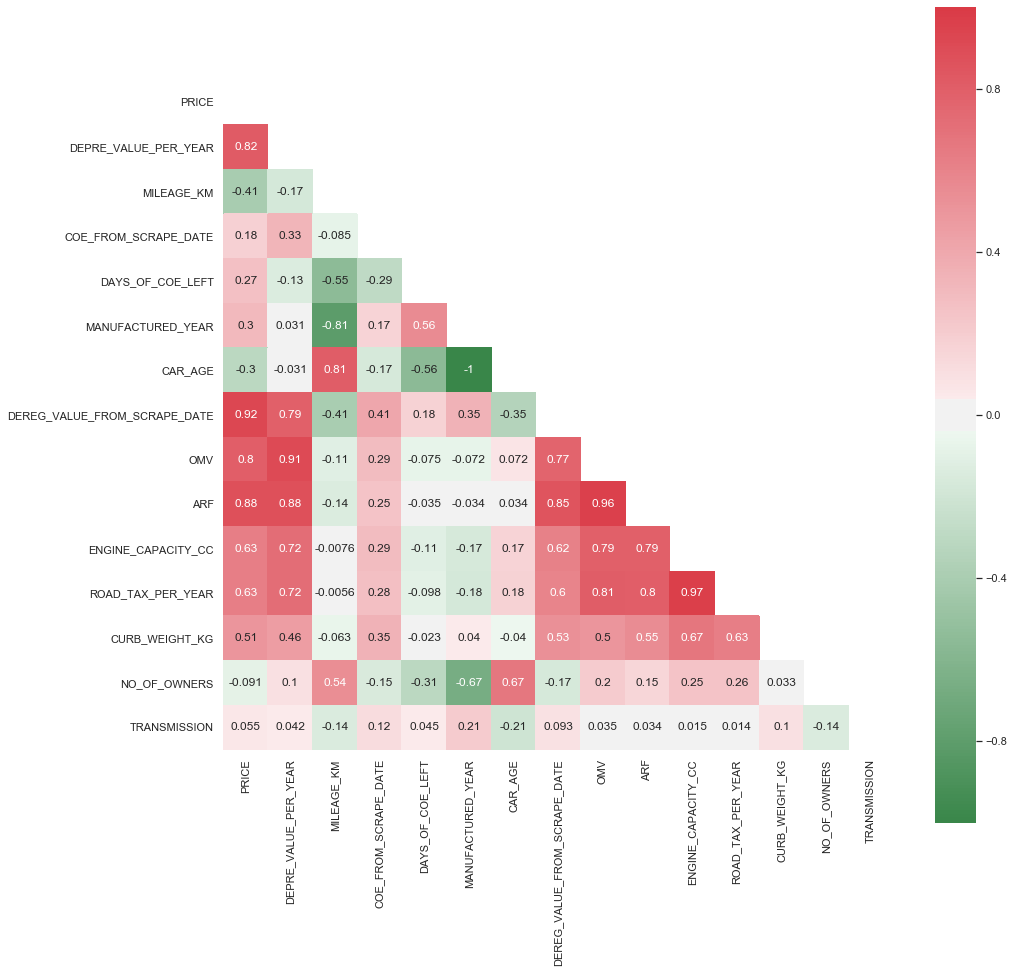

In [27]:
# Corr Matrix Heatmap Visualization

sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.zeros_like(df_price_no_brands.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure to control size of heatmap
fig, ax = plt.subplots(figsize=(15,15))

# Create a custom color palette
cmap = \
sns.diverging_palette(133, 10,
                      as_cmap=True)  # as_cmap returns a matplotlib colormap object rather than a list of colors
# Green = Good (low correlation), Red = Bad (high correlation) between the independent variables

# Plot the heatmap
sns.heatmap(df_price_no_brands.corr(), mask=mask, annot=True, 
            square=True, cmap=cmap , vmin=-1, vmax=1,ax=ax);

# Prevent Heatmap Cut-Off Issue
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

#### From the above Corr Matrix, we can observe that a few Independent Variables are highly correlated with each other. 
Interestingly, this makes sense due to how a few of the independent variables are calculated. Therefore, some of these features can be dropped.  
1. **OMV and ARF:** 
The Additional Registration Fee (ARF) is a tax imposed upon registration of a vehicle. It is calculated based on a percentage of the Open Market Value (OMV) of the vehicle. From the correlation matrix, they have a correlation of **0.96.** Therefore, we can just keep one of this. Therefore, **ARF** will be dropped.
   
   
2. **Engine CC and Road Tax:** 
Road tax increases as engine CC increases. Therefore, having Road Tax in it would be introducing multicolinearity into the model, since both explain the same thing anyway. From the correlation matrix, they have a correlation of **0.97**. Therefore, **road tax** column will be dropped.
   
   
3. **Manufactured Year and Car Age:** 
Obviously, manufactured year can be dropped, since Car Age is derived from year of manufacture. And since car age is more intuitive, **Manufactured Year** column will be dropped.  From the correlation matrix, they have a correlation of **-1**. 
  

  
4. **Dereg Value:**  
The deregistration value of a vehicle is amount one will get back from the government upon deregistering the vehicle for use in Singapore. It is the sum of the COE rebate and the PARF rebate.
The COE rebate is a percentage of the original COE value.
The PARF rebate is a percentage of the original OMV (Open Market Value).
Therefore, the **dereg value will be dropped**. From the corr matrix, OMV and dereg value have a correlation of **0.91.**
  
  
5. **Depreciation:** 
Annual depreciation is the amount the owner loses on the value of the vehicle per year based on the assumption that the vehicle is deregistered only at the end of its 10-yr COE life-span. The value of the car body has not been taken into account.  The formula used to derive the figure is as follows:  
Depreciation = (List Price - Minimum PARF value) ÷ remaining years of COE  
The minimum Preferential Additional Registration Fee (PARF) value is a sum of money that the vehicle owner gets for deregistering his vehicle at the end of its 10-yr COE. It is a function of the Open Market Value (OMV) or Additional Registration Fee (ARF). Commercial vehicles and cars with renewed COE have no minimum PARF value.  Depreciation and OMV have a correlation of **0.91**. **Depreciation** will be dropped.


### Section 3.1.2: Removing Independent Variables with High Correlation to each other

In [28]:
df_price_no_brands.drop(['DEPRE_VALUE_PER_YEAR','REG_DATE','MANUFACTURED_YEAR','DEREG_VALUE_FROM_SCRAPE_DATE',
                         'ARF','ROAD_TAX_PER_YEAR','VEHICLE_TYPE'],axis=1,inplace=True)
df_price_no_brands.columns

C:\Users\xianj\Anaconda3\envs\metis\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Index(['PRICE', 'MILEAGE_KM', 'COE_FROM_SCRAPE_DATE', 'DAYS_OF_COE_LEFT',
       'CAR_AGE', 'OMV', 'ENGINE_CAPACITY_CC', 'CURB_WEIGHT_KG',
       'NO_OF_OWNERS', 'TRANSMISSION'],
      dtype='object')

### Section 3.1.3: Re-Visualizing New Correlation Matrix (with a few features dropped)

(10.0, 0.0)

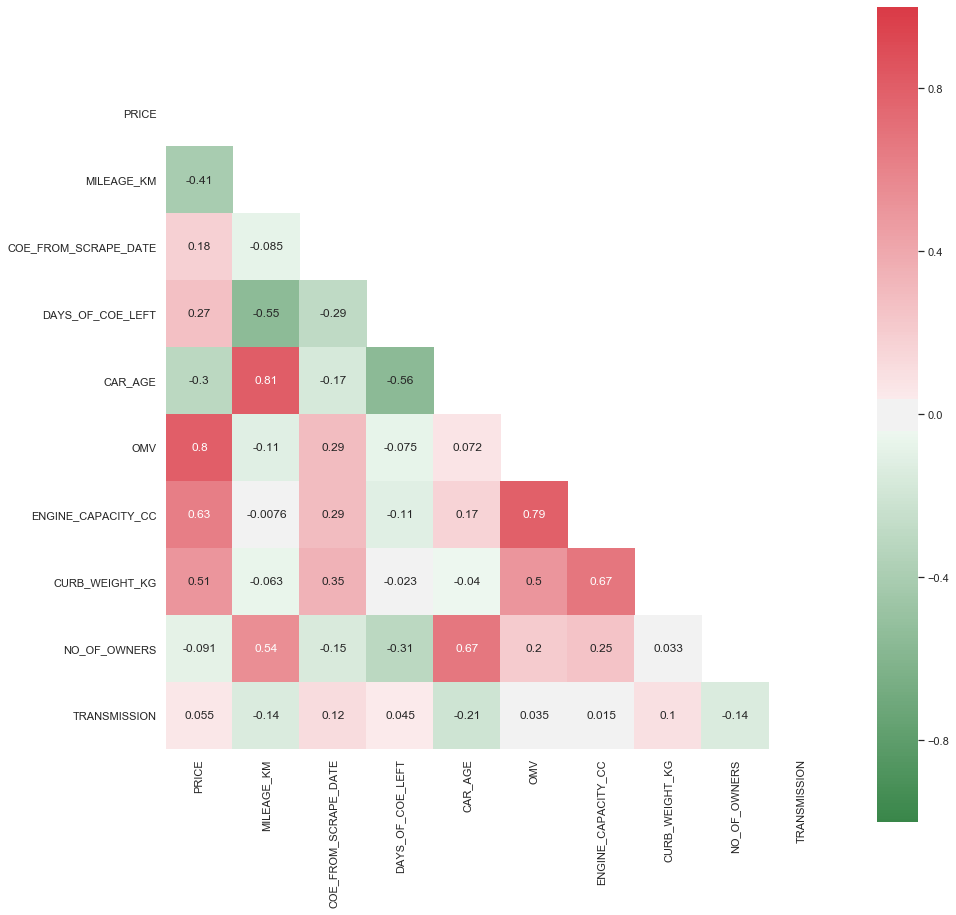

In [29]:
# Re-visualizing the correlation matrix

sns.set(style="white")

# Creating the data
data = df_price_no_brands.corr()


# Generate a mask for the upper triangle
mask = np.zeros_like(data, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure to control size of heatmap
fig, ax = plt.subplots(figsize=(15,15))

# Create a custom color palette
cmap = \
sns.diverging_palette(133, 10,
                      as_cmap=True)  # as_cmap returns a matplotlib colormap object rather than a list of colors
# Green = Good (low correlation), Red = Bad (high correlation) between the independent variables

# Plot the heatmap
sns.heatmap(data, mask=mask, annot=True, 
            square=True, cmap=cmap , vmin=-1, vmax=1,ax=ax);

# Prevent Heatmap Cut-Off Issue
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

In [30]:
# Correlations of the independent variables (features) to dependent variable (target, price)
df_price_no_brands.corr()['PRICE'].sort_values(ascending=False)

PRICE                   1.000000
OMV                     0.801592
ENGINE_CAPACITY_CC      0.630484
CURB_WEIGHT_KG          0.505194
DAYS_OF_COE_LEFT        0.273379
COE_FROM_SCRAPE_DATE    0.182914
TRANSMISSION            0.054688
NO_OF_OWNERS           -0.090614
CAR_AGE                -0.304888
MILEAGE_KM             -0.409517
Name: PRICE, dtype: float64

#### Section 3.1.3.1: Pairplot after Feature Selection

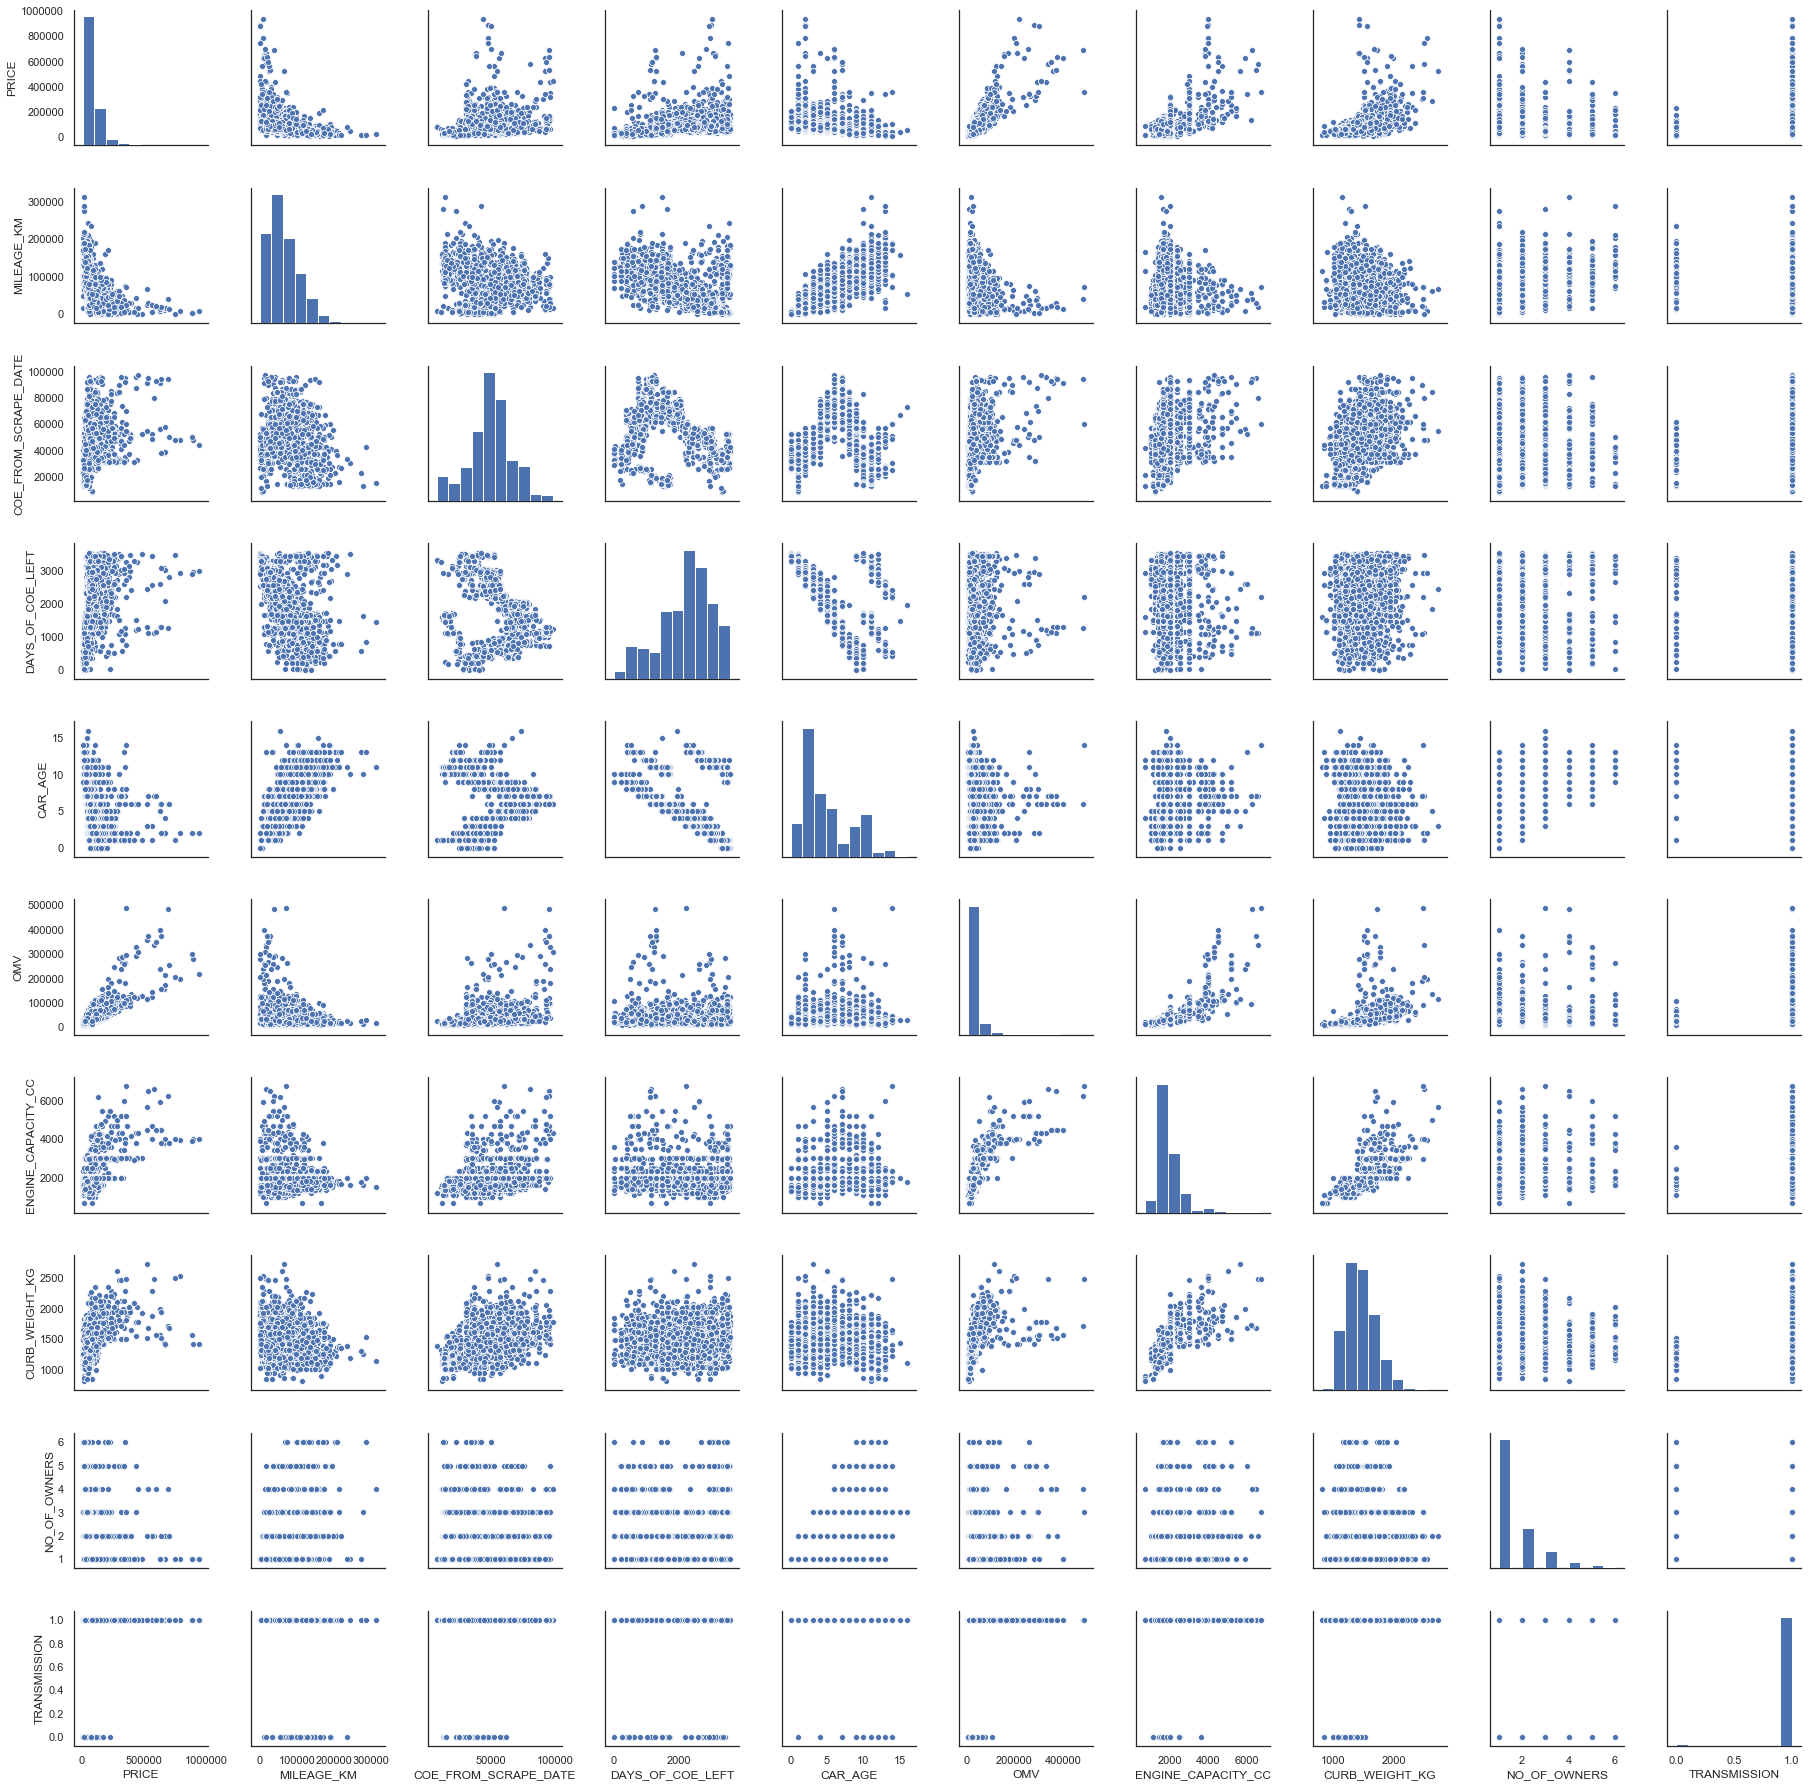

In [31]:
# Performing a pairplot to visualize the data trends of the variables

# We can see that price and mileage hold a negative linear relationship
# COE from the scrape date doesn't seem to have a very clear relatonship here
# Days of COE seems to have a slight linear r/s
# Car age doesn't seem to have a very distinct relationship here. But generally, the younger the car, the higher the price
# OMV has a clear increasing linear rs with price with price
# Engine capacity seems to also have a increasing linear r/s  with price, with a few outliers in the center
# Perhaps it's because a lot of the higher-priced cars (higher brands) are produced in that engine capacity range?
# Curb weight seems to have a linear r/s too.

sns.pairplot(df_price_no_brands);

In [32]:
df_price_no_brands.columns

Index(['PRICE', 'MILEAGE_KM', 'COE_FROM_SCRAPE_DATE', 'DAYS_OF_COE_LEFT',
       'CAR_AGE', 'OMV', 'ENGINE_CAPACITY_CC', 'CURB_WEIGHT_KG',
       'NO_OF_OWNERS', 'TRANSMISSION'],
      dtype='object')

### Section 3.2: Preliminary Model fitting to check R^2 Value and P>|t| values of Price and the leftover Independent Variables

In [33]:
# Slicing Data into Independent Variables (Features) and Dependent Variable (Target)
X = df_price_no_brands[ ['MILEAGE_KM', 'COE_FROM_SCRAPE_DATE', 'DAYS_OF_COE_LEFT',
       'CAR_AGE', 'OMV', 'ENGINE_CAPACITY_CC', 'CURB_WEIGHT_KG',
       'NO_OF_OWNERS', 'TRANSMISSION'] ].astype(float)
X = sm.add_constant(X)
y = df_price_no_brands['PRICE'].astype(float)



C:\Users\xianj\Anaconda3\envs\metis\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [34]:
X.head()

const  MILEAGE_KM  COE_FROM_SCRAPE_DATE  DAYS_OF_COE_LEFT  CAR_AGE  \
3    1.0    140800.0               75889.0             761.0      8.0   
4    1.0    117000.0               39563.0            3503.0     10.0   
5    1.0    126000.0               41006.0               8.0      9.0   
7    1.0     41000.0               78810.0            1610.0      6.0   
9    1.0     57784.0               61103.0            2221.0      4.0   

       OMV  ENGINE_CAPACITY_CC  CURB_WEIGHT_KG  NO_OF_OWNERS  TRANSMISSION  
3  71379.0              2995.0          2250.0           3.0           1.0  
4  23465.0              1797.0          1350.0           2.0           1.0  
5  56154.0              1796.0          1650.0           4.0           1.0  
7  32459.0              1598.0          1405.0           2.0           1.0  
9  29913.0              1395.0          1480.0           2.0           1.0

In [35]:
y.head()

3    70800.0
4    65800.0
5    45000.0
7    70800.0
9    89500.0
Name: PRICE, dtype: float64

In [36]:
# model / fit / summarize
import statsmodels.api as sm

lsm = sm.OLS(y, X)
results = lsm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  PRICE   R-squared:                       0.820
Model:                            OLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                     1302.
Date:                Sun, 03 Nov 2019   Prob (F-statistic):               0.00
Time:                        15:22:48   Log-Likelihood:                -30542.
No. Observations:                2584   AIC:                         6.110e+04
Df Residuals:                    2574   BIC:                         6.116e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 3.484e+04   8210.482      4.244      0.000    1.87e+04    5.09e+04
MILEAGE_KM               0.0137      0.029      0.474      0.636      -0.043       0.070
COE_FROM_SCRAPE_DATE    -0.5149      0.050    -10.225      0.000      -0.614      -0.416
DAYS_OF_COE_LEFT        13.5465      1.117     12.129      0.000      11.357      15.737
CAR_AGE              -6613.2165    441.423    -14.982      0.000   -7478.797   -5747.636
OMV                      1.6947      0.030     55.901      0.000       1.635       1.754
ENGINE_CAPACITY_CC       3.7436      1.944      1.926      0.054      -0.068       7.556
CURB_WEIGHT_KG          38.2517      3.685     10.381      0.000      31.026      45.477
NO_OF_OWNERS         -5312.6178    941.160     -5.645      0.000   -7158.125   -3467.110
TRANSMISSION          -2.83e+04   5624.584     -5.031      0.000   -3.93e+04   -1.73e+04
==============================================================================
Omnibus:                     2049.653   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           458170.330
Skew:                           2.828   Prob(JB):                         0.00
Kurtosis:                      67.988   Cond. No.                     1.36e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.36e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Section 3.2.1: Optimizing R^2 Value

#### Section 3.2.1.1: Checking Distributions & Pairplots of all Variables

##### Pairplot of Price vs Independent Variables (without any transformation)

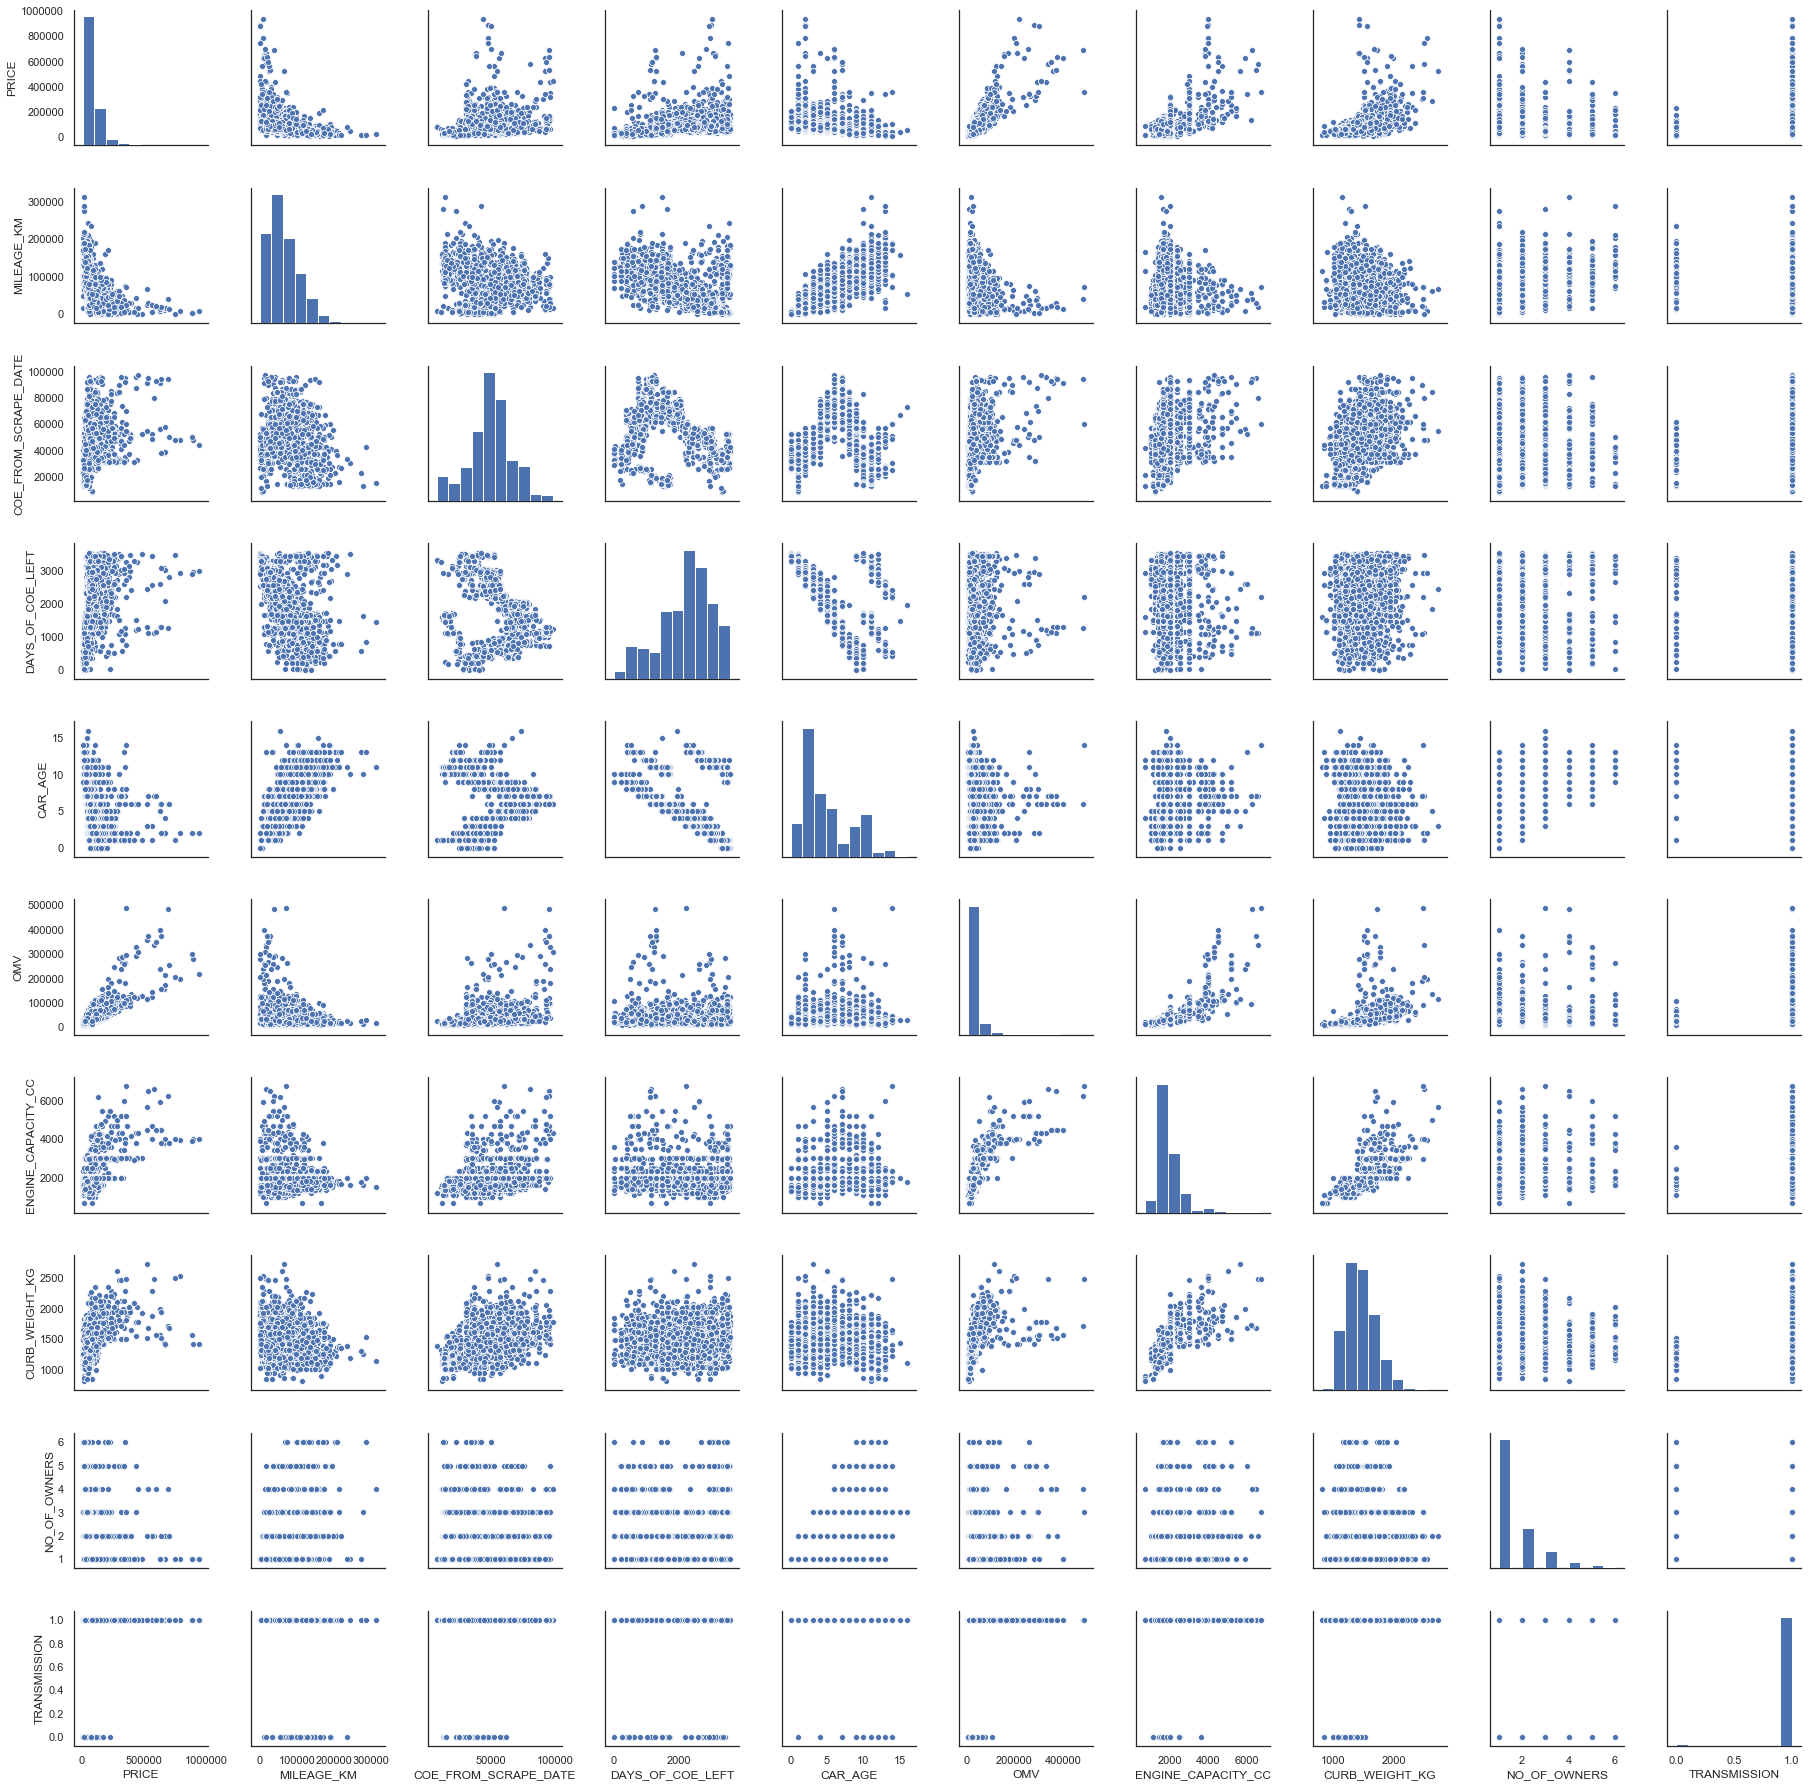

In [47]:
# Performing a pairplot to visualize the data trends of the variables

# We can see that price and mileage hold a negative linear relationship
# COE from the scrape date doesn't seem to have a very clear relatonship here
# Days of COE seems to have a slight linear r/s
# Car age doesn't seem to have a very distinct relationship here. But generally, the younger the car, the higher the price
# OMV has a clear increasing linear rs with price with price
# Engine capacity seems to also have a increasing linear r/s  with price, with a few outliers in the center
# Perhaps it's because a lot of the higher-priced cars (higher brands) are produced in that engine capacity range?
# Curb weight seems to have a linear r/s too.

sns.pairplot(df_price_no_brands);

##### Histograph of all Variables (Columns) in DataFrame

C:\Users\xianj\Anaconda3\envs\metis\lib\site-packages\ipykernel_launcher.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000286B6F20A90>,
      dtype=object)

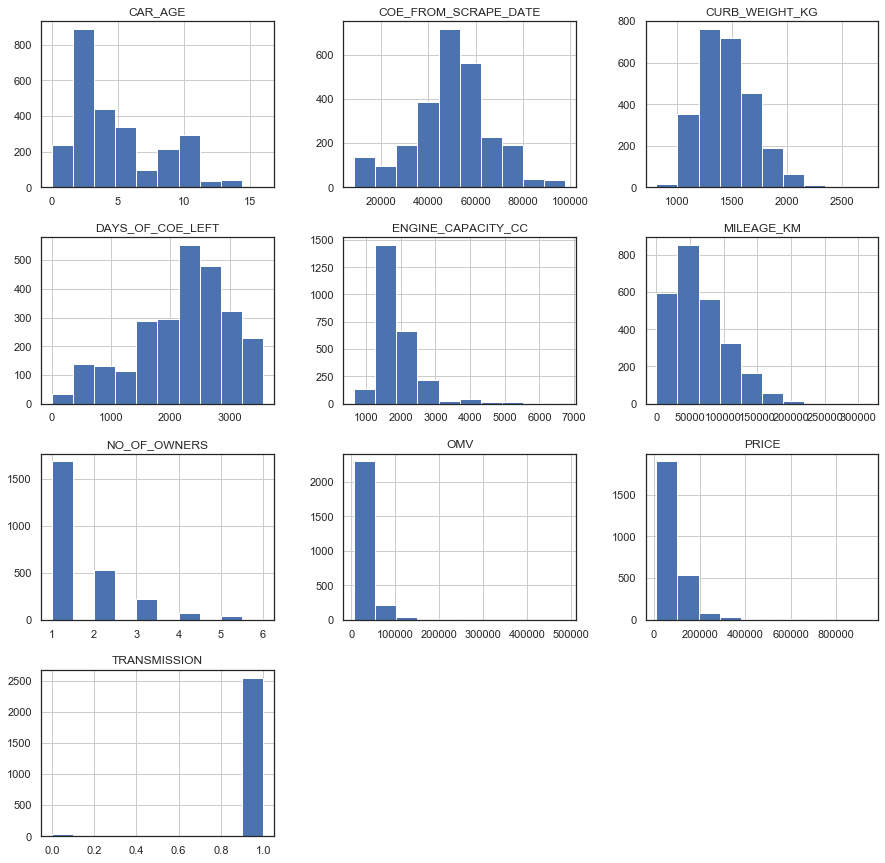

In [48]:
fig, ax = plt.subplots(figsize=(15,15))
pd.DataFrame.hist(df_price_no_brands,ax=ax)

In [49]:
# From the above graphs, it would make sense to apply log transform on the following variables to make them
# more normally distributed
# Mileage
# Engine Cap
# Price
# OMV

## Distribution of Price

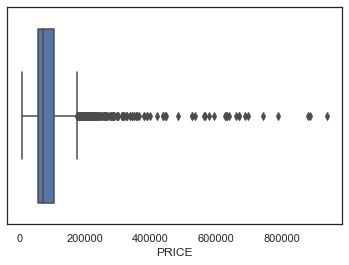

In [53]:
sns.boxplot(df_price_no_brands['PRICE'])  # 

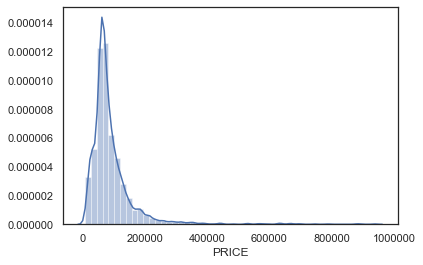

In [54]:
sns.distplot(df_price_no_brands['PRICE'])  # Your dependent variable 'must' be normally distributed

In [38]:
# We see that price is right-skewed. Therefore, we can try applying a log onto price, then visualize the data again.

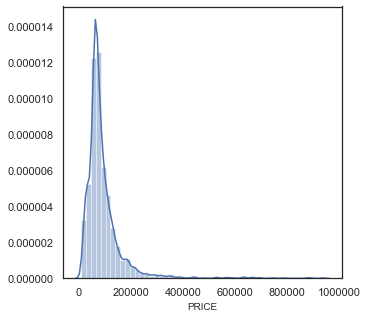

In [39]:
fig, ax = plt.subplots(figsize=(5,5))
sns.distplot(df_price_no_brands['PRICE'],ax=ax)
plt.xlabel('PRICE',size=10)
plt.savefig("price_no_log.png",transparent=True)

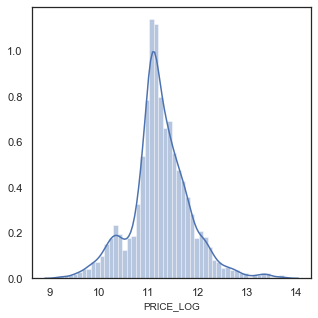

In [40]:
fig, ax = plt.subplots(figsize=(5,5))
sns.distplot(np.log(df_price_no_brands['PRICE']),ax=ax)
plt.xlabel("PRICE_LOG",size=10)
plt.savefig("price_log.png",transparent=True)

### Section 3.2.1: Logging Mileage ONLY

In [41]:
# Creating a copy of the dataframe to work log on
df_price_no_brands_only_mileage_logged = df_price_no_brands.copy()

In [42]:
# Log Mileage
df_price_no_brands_only_mileage_logged["MILEAGE_LOG"] = df_price_no_brands_only_mileage_logged['MILEAGE_KM'].apply(np.log)
df_price_no_brands_only_mileage_logged

PRICE  MILEAGE_KM  COE_FROM_SCRAPE_DATE  DAYS_OF_COE_LEFT  CAR_AGE  \
3      70800.0    140800.0               75889.0             761.0      8.0   
4      65800.0    117000.0               39563.0            3503.0     10.0   
5      45000.0    126000.0               41006.0               8.0      9.0   
7      70800.0     41000.0               78810.0            1610.0      6.0   
9      89500.0     57784.0               61103.0            2221.0      4.0   
...        ...         ...                   ...               ...      ...   
3981  103800.0     19000.0               53694.0            2434.0      3.0   
3982  104500.0     47638.0               84504.0            1679.0      5.0   
3983  115000.0     51500.0               67901.0            1950.0      7.0   
3984  119800.0     16000.0               53300.0            2769.0      2.0   
3985   81800.0     53339.0               57501.0            2462.0      4.0   

          OMV  ENGINE_CAPACITY_CC  CURB_WEIGHT_KG  NO_OF_OWNERS  TRANSMISSION  \
3     71379.0                2995          2250.0           3.0             1   
4     23465.0                1797          1350.0           2.0             1   
5     56154.0                1796          1650.0           4.0             1   
7     32459.0                1598          1405.0           2.0             1   
9     29913.0                1395          1480.0           2.0             1   
...       ...                 ...             ...           ...           ...   
3981  27886.0                1595          1430.0           1.0             1   
3982  45977.0                3456          2030.0           2.0             1   
3983  52051.0                1796          1600.0           2.0             1   
3984  33570.0                1998          1390.0           1.0             1   
3985  26629.0                2488          1510.0           1.0             1   

      MILEAGE_LOG  
3       11.855096  
4       11.669929  
5       11.744037  
7       10.621327  
9       10.964467  
...           ...  
3981     9.852194  
3982    10.771386  
3983    10.849337  
3984     9.680344  
3985    10.884423  

[2584 rows x 11 columns]

In [43]:
# Rearranging columns

df_price_no_brands_only_mileage_logged = \
df_price_no_brands_only_mileage_logged[['PRICE', 'MILEAGE_LOG', 'COE_FROM_SCRAPE_DATE', 'DAYS_OF_COE_LEFT',
       'CAR_AGE', 'OMV', 'ENGINE_CAPACITY_CC', 'CURB_WEIGHT_KG',
       'NO_OF_OWNERS', 'TRANSMISSION']]

In [44]:
df_price_no_brands_only_mileage_logged.columns

Index(['PRICE', 'MILEAGE_LOG', 'COE_FROM_SCRAPE_DATE', 'DAYS_OF_COE_LEFT',
       'CAR_AGE', 'OMV', 'ENGINE_CAPACITY_CC', 'CURB_WEIGHT_KG',
       'NO_OF_OWNERS', 'TRANSMISSION'],
      dtype='object')

In [45]:
# Slicing Data into Independent Variables (Features) and Dependent Variable (Target)
X = df_price_no_brands_only_mileage_logged[ ['MILEAGE_LOG', 'COE_FROM_SCRAPE_DATE', 'DAYS_OF_COE_LEFT',
       'CAR_AGE', 'OMV', 'ENGINE_CAPACITY_CC', 'CURB_WEIGHT_KG',
       'NO_OF_OWNERS', 'TRANSMISSION'] ].astype(float)
X = sm.add_constant(X)
y = df_price_no_brands_only_mileage_logged['PRICE'].astype(float)


# model / fit / summarize
import statsmodels.api as sm

lsm = sm.OLS(y, X)
results = lsm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  PRICE   R-squared:                       0.824
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     1338.
Date:                Sun, 03 Nov 2019   Prob (F-statistic):               0.00
Time:                        15:24:59   Log-Likelihood:                -30513.
No. Observations:                2584   AIC:                         6.105e+04
Df Residuals:                    2574   BIC:                         6.110e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 1.014e+05   1.18e+04      8.561      0.000    7.82e+04    1.25e+05
MILEAGE_LOG          -7085.1532    920.002     -7.701      0.000   -8889.172   -5281.134
COE_FROM_SCRAPE_DATE    -0.3993      0.052     -7.717      0.000      -0.501      -0.298
DAYS_OF_COE_LEFT        12.3075      1.099     11.203      0.000      10.153      14.462
CAR_AGE              -5061.4371    385.572    -13.127      0.000   -5817.500   -4305.374
OMV                      1.6409      0.030     54.319      0.000       1.582       1.700
ENGINE_CAPACITY_CC       3.5621      1.909      1.866      0.062      -0.182       7.306
CURB_WEIGHT_KG          38.1714      3.610     10.575      0.000      31.093      45.250
NO_OF_OWNERS         -5117.4490    923.990     -5.538      0.000   -6929.287   -3305.611
TRANSMISSION         -2.629e+04   5563.914     -4.725      0.000   -3.72e+04   -1.54e+04
==============================================================================
Omnibus:                     2109.523   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           471245.551
Skew:                           2.976   Prob(JB):                         0.00
Kurtosis:                      68.890   Cond. No.                     1.28e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.28e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

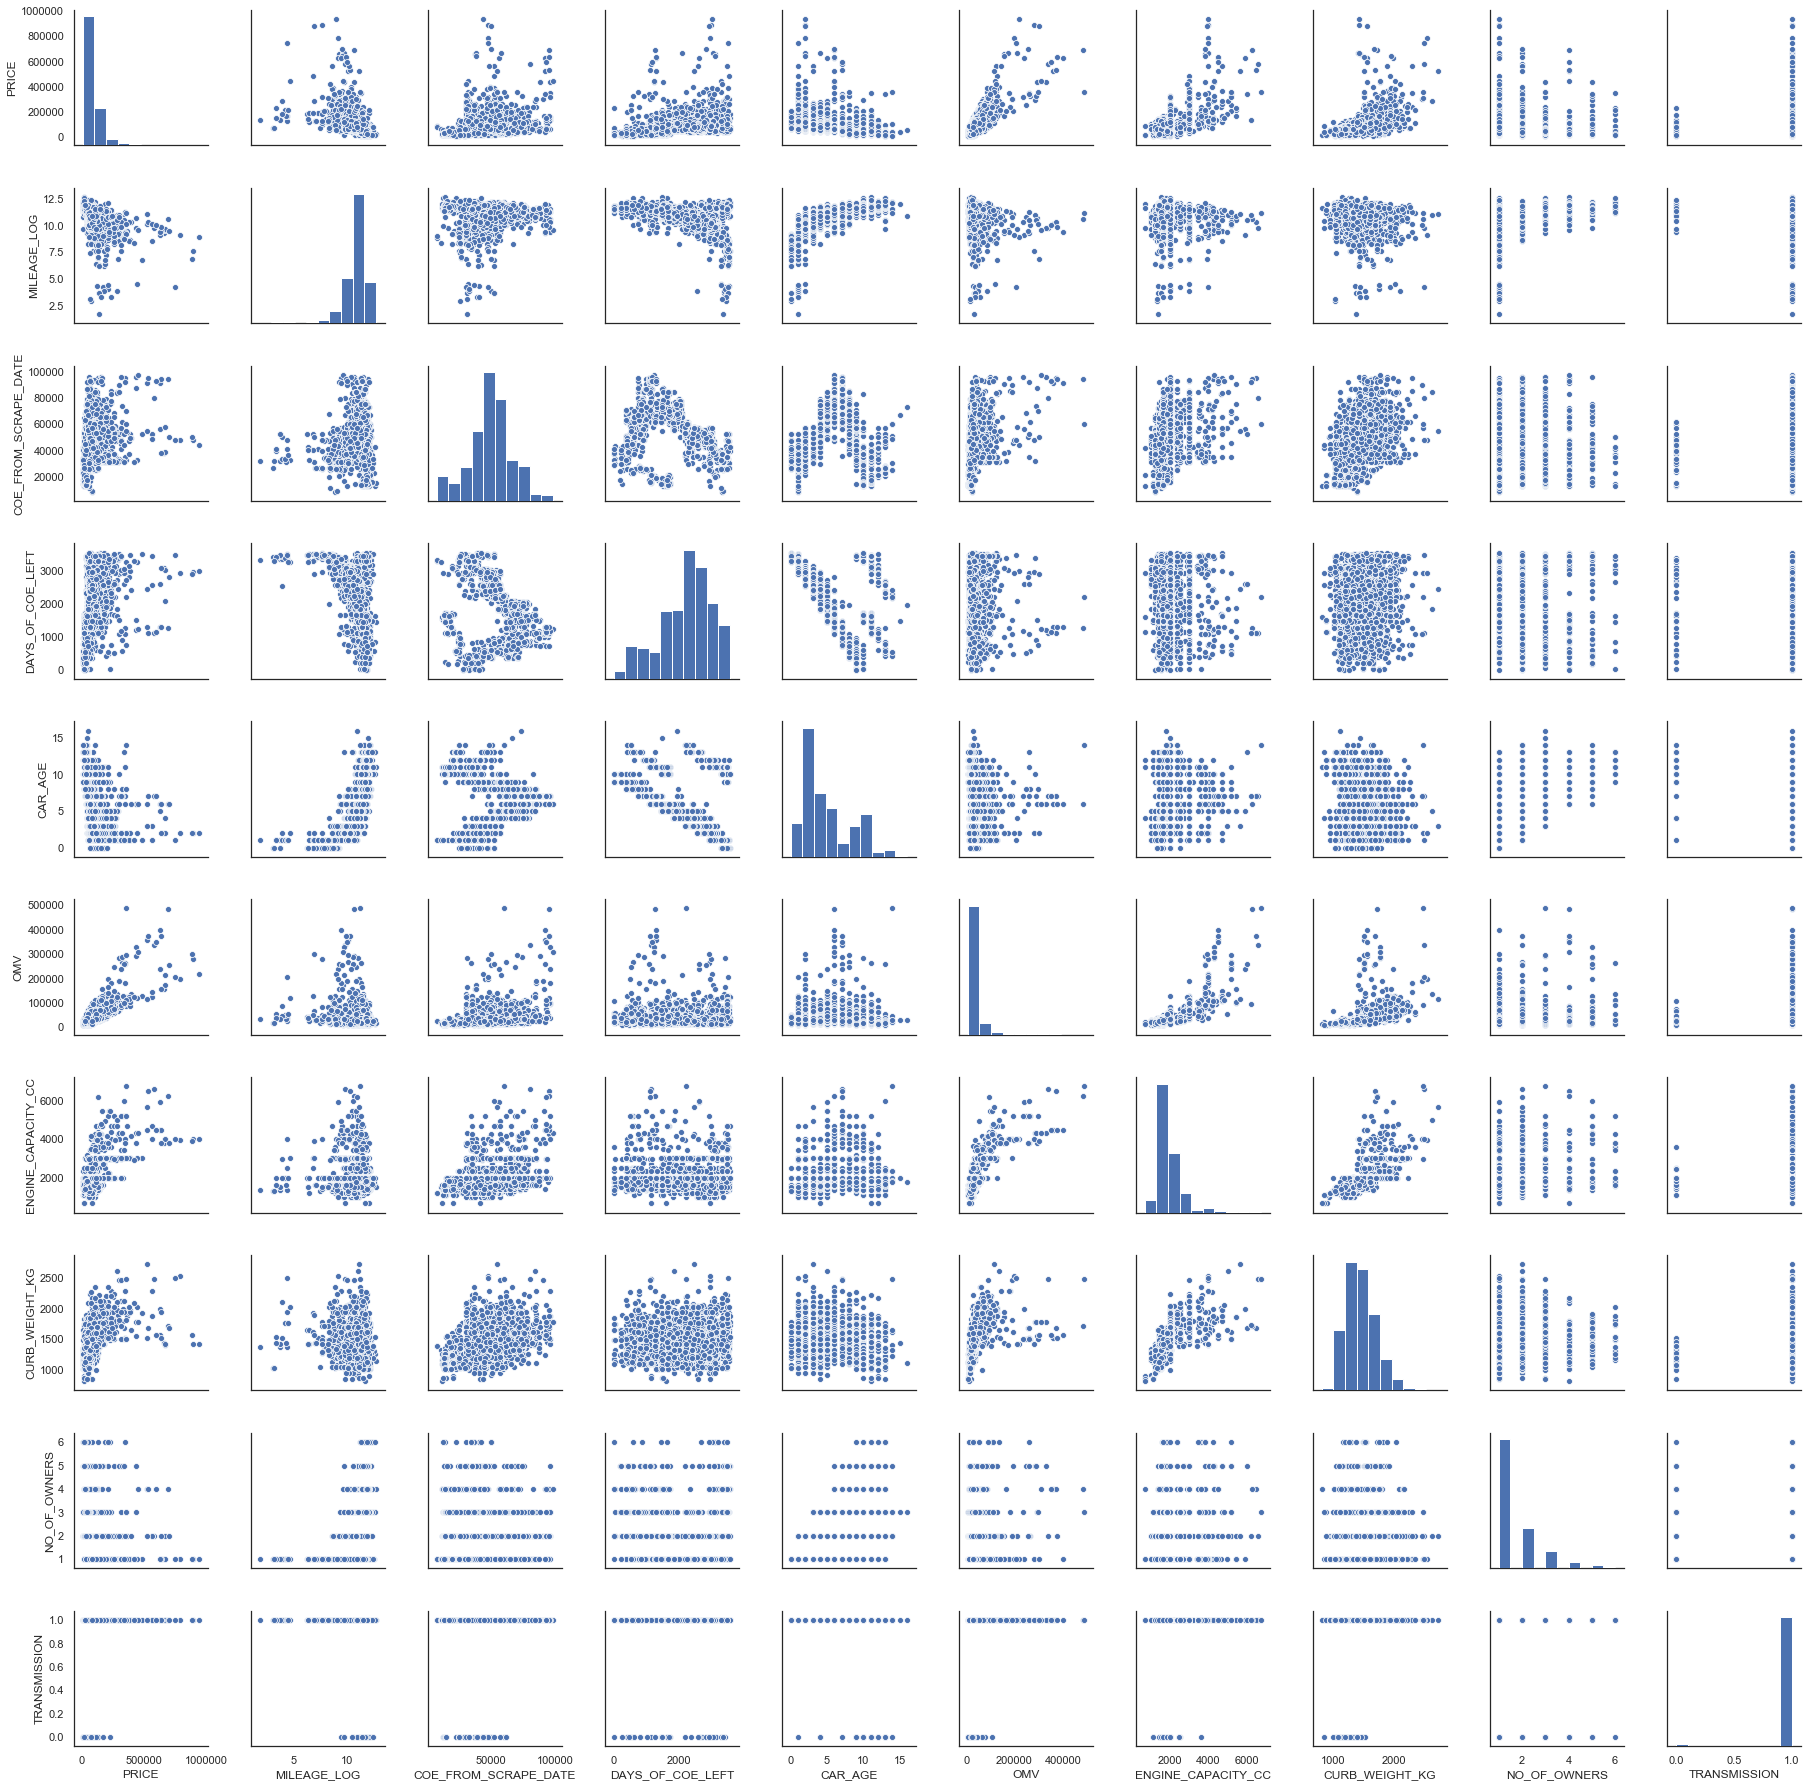

In [46]:
# Visualizing Pairplots of Price vs Other Features and Only Mileage logged

sns.pairplot(df_price_no_brands_only_mileage_logged);

### Section 3.2.2: Normal Price with Logged Mileage and Squared Engine CC

In [47]:
# Creating a copy of the dataframe to work log on
df_price_no_brands_mileage_logged_squared_engine_cap = df_price_no_brands_only_mileage_logged.copy()

In [48]:
# Square Engine CC
df_price_no_brands_mileage_logged_squared_engine_cap["ENGINE_SQUARED"] = \
df_price_no_brands_mileage_logged_squared_engine_cap['ENGINE_CAPACITY_CC'].apply(lambda x: x**2)


In [49]:
df_price_no_brands_mileage_logged_squared_engine_cap.columns

Index(['PRICE', 'MILEAGE_LOG', 'COE_FROM_SCRAPE_DATE', 'DAYS_OF_COE_LEFT',
       'CAR_AGE', 'OMV', 'ENGINE_CAPACITY_CC', 'CURB_WEIGHT_KG',
       'NO_OF_OWNERS', 'TRANSMISSION', 'ENGINE_SQUARED'],
      dtype='object')

In [50]:
# Rearrange columns
df_price_no_brands_mileage_logged_squared_engine_cap = \
df_price_no_brands_mileage_logged_squared_engine_cap[['PRICE', 'MILEAGE_LOG', 'COE_FROM_SCRAPE_DATE', 'DAYS_OF_COE_LEFT',
       'CAR_AGE', 'OMV', 'ENGINE_SQUARED', 'CURB_WEIGHT_KG',
       'NO_OF_OWNERS', 'TRANSMISSION']]

In [51]:
# Slicing Data into Independent Variables (Features) and Dependent Variable (Target)
X = df_price_no_brands_mileage_logged_squared_engine_cap[ ['MILEAGE_LOG', 'COE_FROM_SCRAPE_DATE', 'DAYS_OF_COE_LEFT',
       'CAR_AGE', 'OMV', 'ENGINE_SQUARED', 'CURB_WEIGHT_KG',
       'NO_OF_OWNERS', 'TRANSMISSION'] ].astype(float)
X = sm.add_constant(X)
y = df_price_no_brands_only_mileage_logged['PRICE'].astype(float)


# model / fit / summarize
import statsmodels.api as sm

lsm = sm.OLS(y, X)
results = lsm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  PRICE   R-squared:                       0.824
Model:                            OLS   Adj. R-squared:                  0.824
Method:                 Least Squares   F-statistic:                     1341.
Date:                Sun, 03 Nov 2019   Prob (F-statistic):               0.00
Time:                        15:26:07   Log-Likelihood:                -30510.
No. Observations:                2584   AIC:                         6.104e+04
Df Residuals:                    2574   BIC:                         6.110e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 9.616e+04   1.19e+04      8.056      0.000    7.28e+04     1.2e+05
MILEAGE_LOG          -7057.6003    919.274     -7.677      0.000   -8860.192   -5255.009
COE_FROM_SCRAPE_DATE    -0.3897      0.052     -7.547      0.000      -0.491      -0.288
DAYS_OF_COE_LEFT        12.5789      1.096     11.474      0.000      10.429      14.729
CAR_AGE              -4840.4997    382.773    -12.646      0.000   -5591.074   -4089.925
OMV                      1.7452      0.033     53.676      0.000       1.681       1.809
ENGINE_SQUARED          -0.0009      0.000     -2.829      0.005      -0.002      -0.000
CURB_WEIGHT_KG          44.6986      3.218     13.890      0.000      38.388      51.009
NO_OF_OWNERS         -4876.3993    922.598     -5.286      0.000   -6685.508   -3067.290
TRANSMISSION         -2.669e+04   5557.439     -4.802      0.000   -3.76e+04   -1.58e+04
==============================================================================
Omnibus:                     2124.160   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           481321.897
Skew:                           3.009   Prob(JB):                         0.00
Kurtosis:                      69.590   Cond. No.                     1.06e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.06e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

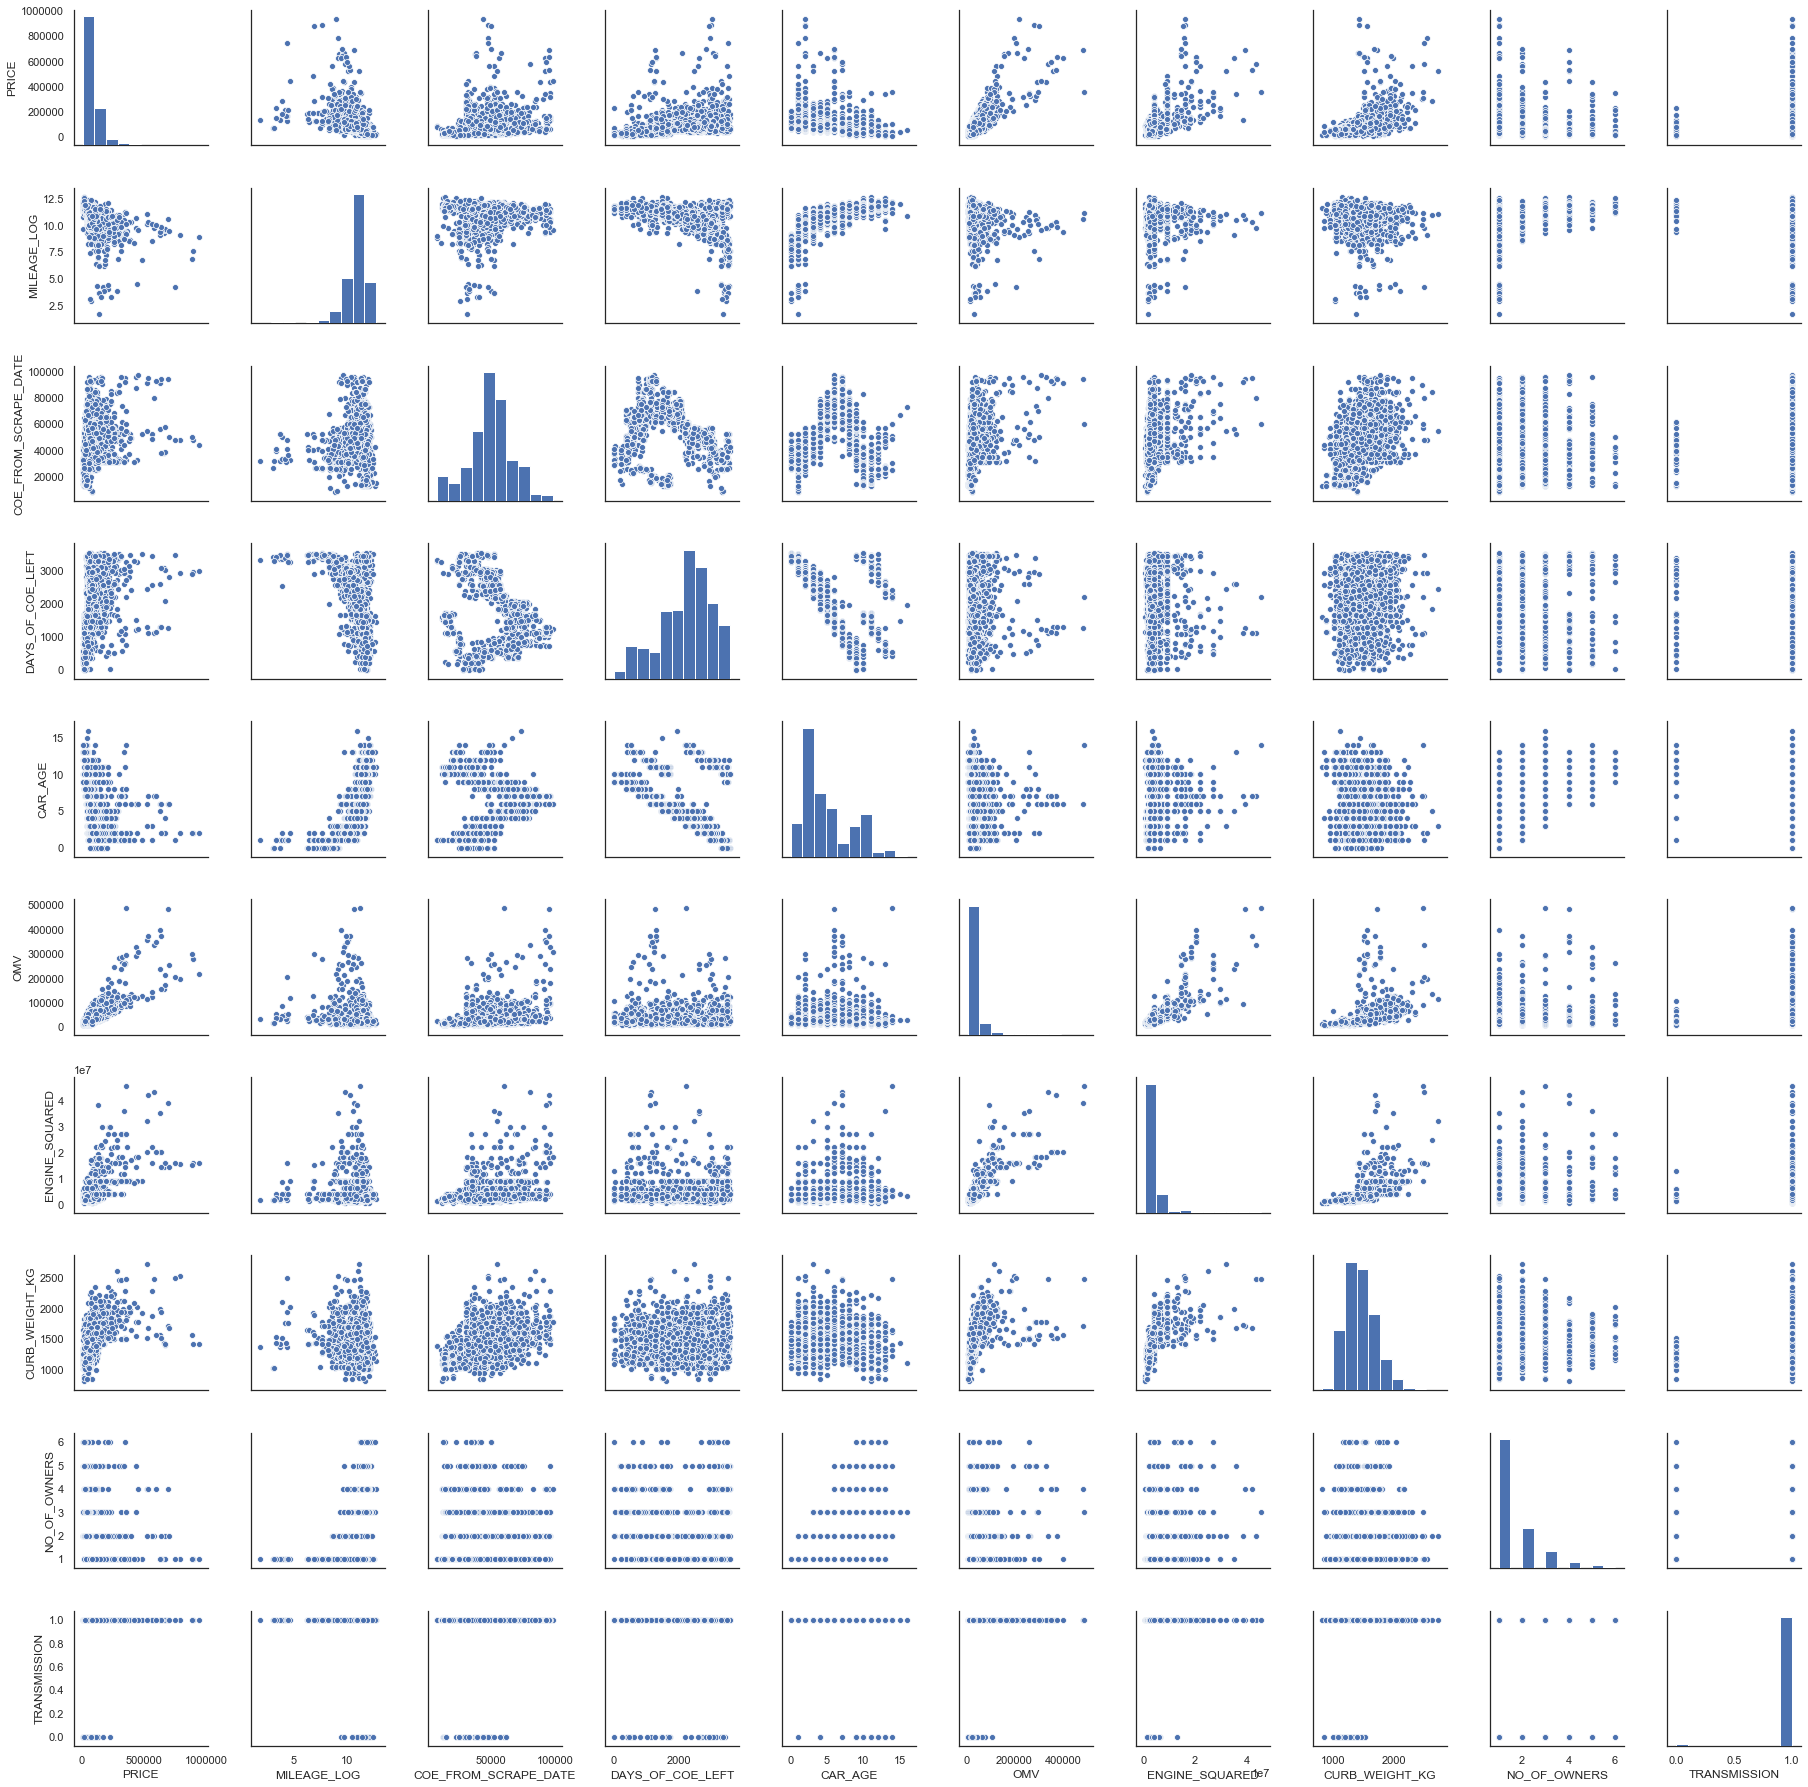

In [52]:
# Visualizing Pairplots of the distributions

sns.pairplot(df_price_no_brands_mileage_logged_squared_engine_cap);

(10.0, 0.0)

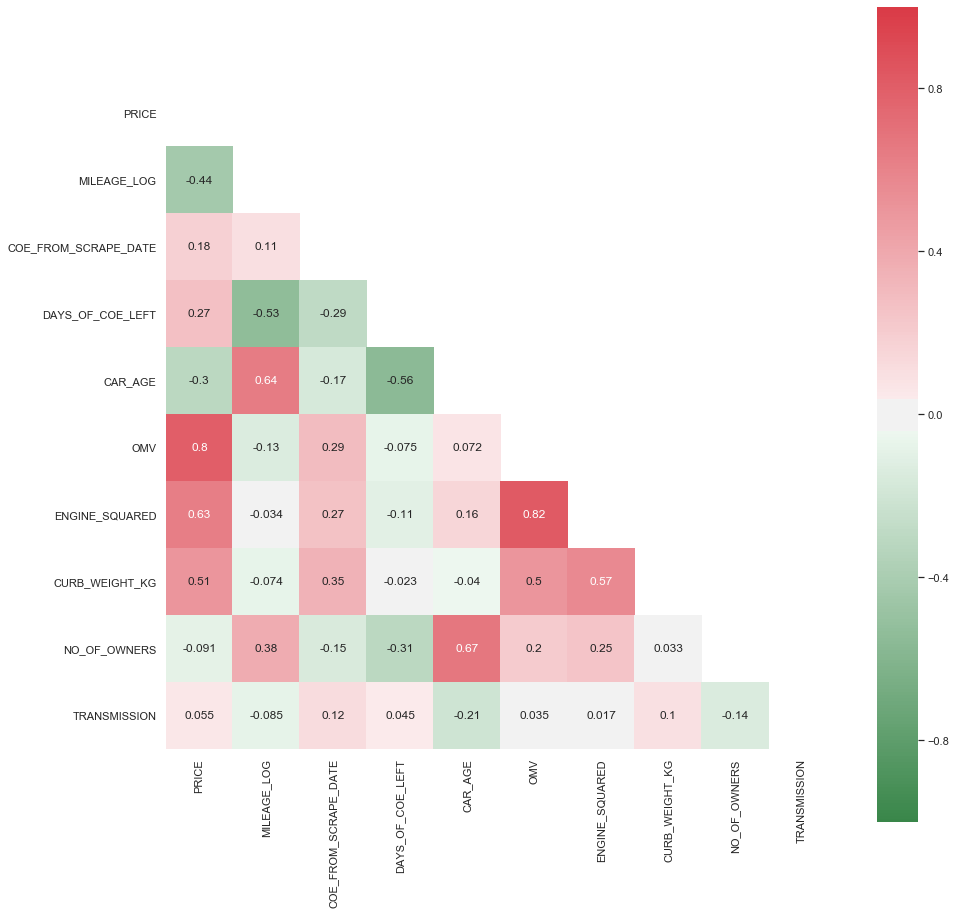

In [53]:
# Viewing Corr Matrix of Price vs Independent Variables (only logged mileage and squared engine CC)

sns.set(style="white")
data = df_price_no_brands_mileage_logged_squared_engine_cap.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(data, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure to control size of heatmap
fig, ax = plt.subplots(figsize=(15,15))

# Create a custom color palette
cmap = \
sns.diverging_palette(133, 10,
                      as_cmap=True)  # as_cmap returns a matplotlib colormap object rather than a list of colors
# Green = Good (low correlation), Red = Bad (high correlation) between the independent variables

# Plot the heatmap
sns.heatmap(data, mask=mask, annot=True, 
            square=True, cmap=cmap , vmin=-1, vmax=1,ax=ax);

# Prevent Heatmap Cut-Off Issue
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

### Section 3.2.3: Logged Price with Logged Mileage and Squared Engine CC

In [54]:
df_logged_price_no_brands_mileage_logged_squared_engine_cap = df_price_no_brands_mileage_logged_squared_engine_cap.copy()

In [55]:
# Logging Price
df_logged_price_no_brands_mileage_logged_squared_engine_cap['PRICE_LOG'] =\
df_logged_price_no_brands_mileage_logged_squared_engine_cap['PRICE'].apply(np.log)

In [56]:
# Rearrange columns
df_logged_price_no_brands_mileage_logged_squared_engine_cap = \
df_logged_price_no_brands_mileage_logged_squared_engine_cap[['PRICE_LOG', 'MILEAGE_LOG', 'COE_FROM_SCRAPE_DATE', 'DAYS_OF_COE_LEFT',
       'CAR_AGE', 'OMV', 'ENGINE_SQUARED', 'CURB_WEIGHT_KG',
       'NO_OF_OWNERS', 'TRANSMISSION']]

In [57]:
# Slicing Data into Independent Variables (Features) and Dependent Variable (Target)
X = df_logged_price_no_brands_mileage_logged_squared_engine_cap[ ['MILEAGE_LOG', 'COE_FROM_SCRAPE_DATE', 'DAYS_OF_COE_LEFT',
       'CAR_AGE', 'OMV', 'ENGINE_SQUARED', 'CURB_WEIGHT_KG',
       'NO_OF_OWNERS', 'TRANSMISSION'] ].astype(float)
X = sm.add_constant(X)
y = df_logged_price_no_brands_mileage_logged_squared_engine_cap['PRICE_LOG'].astype(float)


# model / fit / summarize
import statsmodels.api as sm

lsm = sm.OLS(y, X)
results = lsm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              PRICE_LOG   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.897
Method:                 Least Squares   F-statistic:                     2494.
Date:                Sun, 03 Nov 2019   Prob (F-statistic):               0.00
Time:                        15:27:01   Log-Likelihood:                 572.30
No. Observations:                2584   AIC:                            -1125.
Df Residuals:                    2574   BIC:                            -1066.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    9.8017      0.071    137.568      0.000       9.662       9.941
MILEAGE_LOG             -0.0281      0.005     -5.119      0.000      -0.039      -0.017
COE_FROM_SCRAPE_DATE  5.929e-06   3.08e-07     19.236      0.000    5.32e-06    6.53e-06
DAYS_OF_COE_LEFT         0.0003   6.54e-06     42.906      0.000       0.000       0.000
CAR_AGE                 -0.0598      0.002    -26.174      0.000      -0.064      -0.055
OMV                    7.97e-06   1.94e-07     41.062      0.000    7.59e-06    8.35e-06
ENGINE_SQUARED       -7.988e-10   1.88e-09     -0.425      0.671   -4.49e-09    2.89e-09
CURB_WEIGHT_KG           0.0007   1.92e-05     36.108      0.000       0.001       0.001
NO_OF_OWNERS            -0.0032      0.006     -0.573      0.567      -0.014       0.008
TRANSMISSION            -0.1599      0.033     -4.820      0.000      -0.225      -0.095
==============================================================================
Omnibus:                      555.253   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10930.932
Skew:                          -0.490   Prob(JB):                         0.00
Kurtosis:                      13.028   Cond. No.                     1.06e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.06e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Section 3.2.3: Logged Price with Logged Mileage only (no engine squared)

In [58]:
df_logged_price_no_brands_only_mileage_logged = df_price_no_brands_only_mileage_logged.copy()

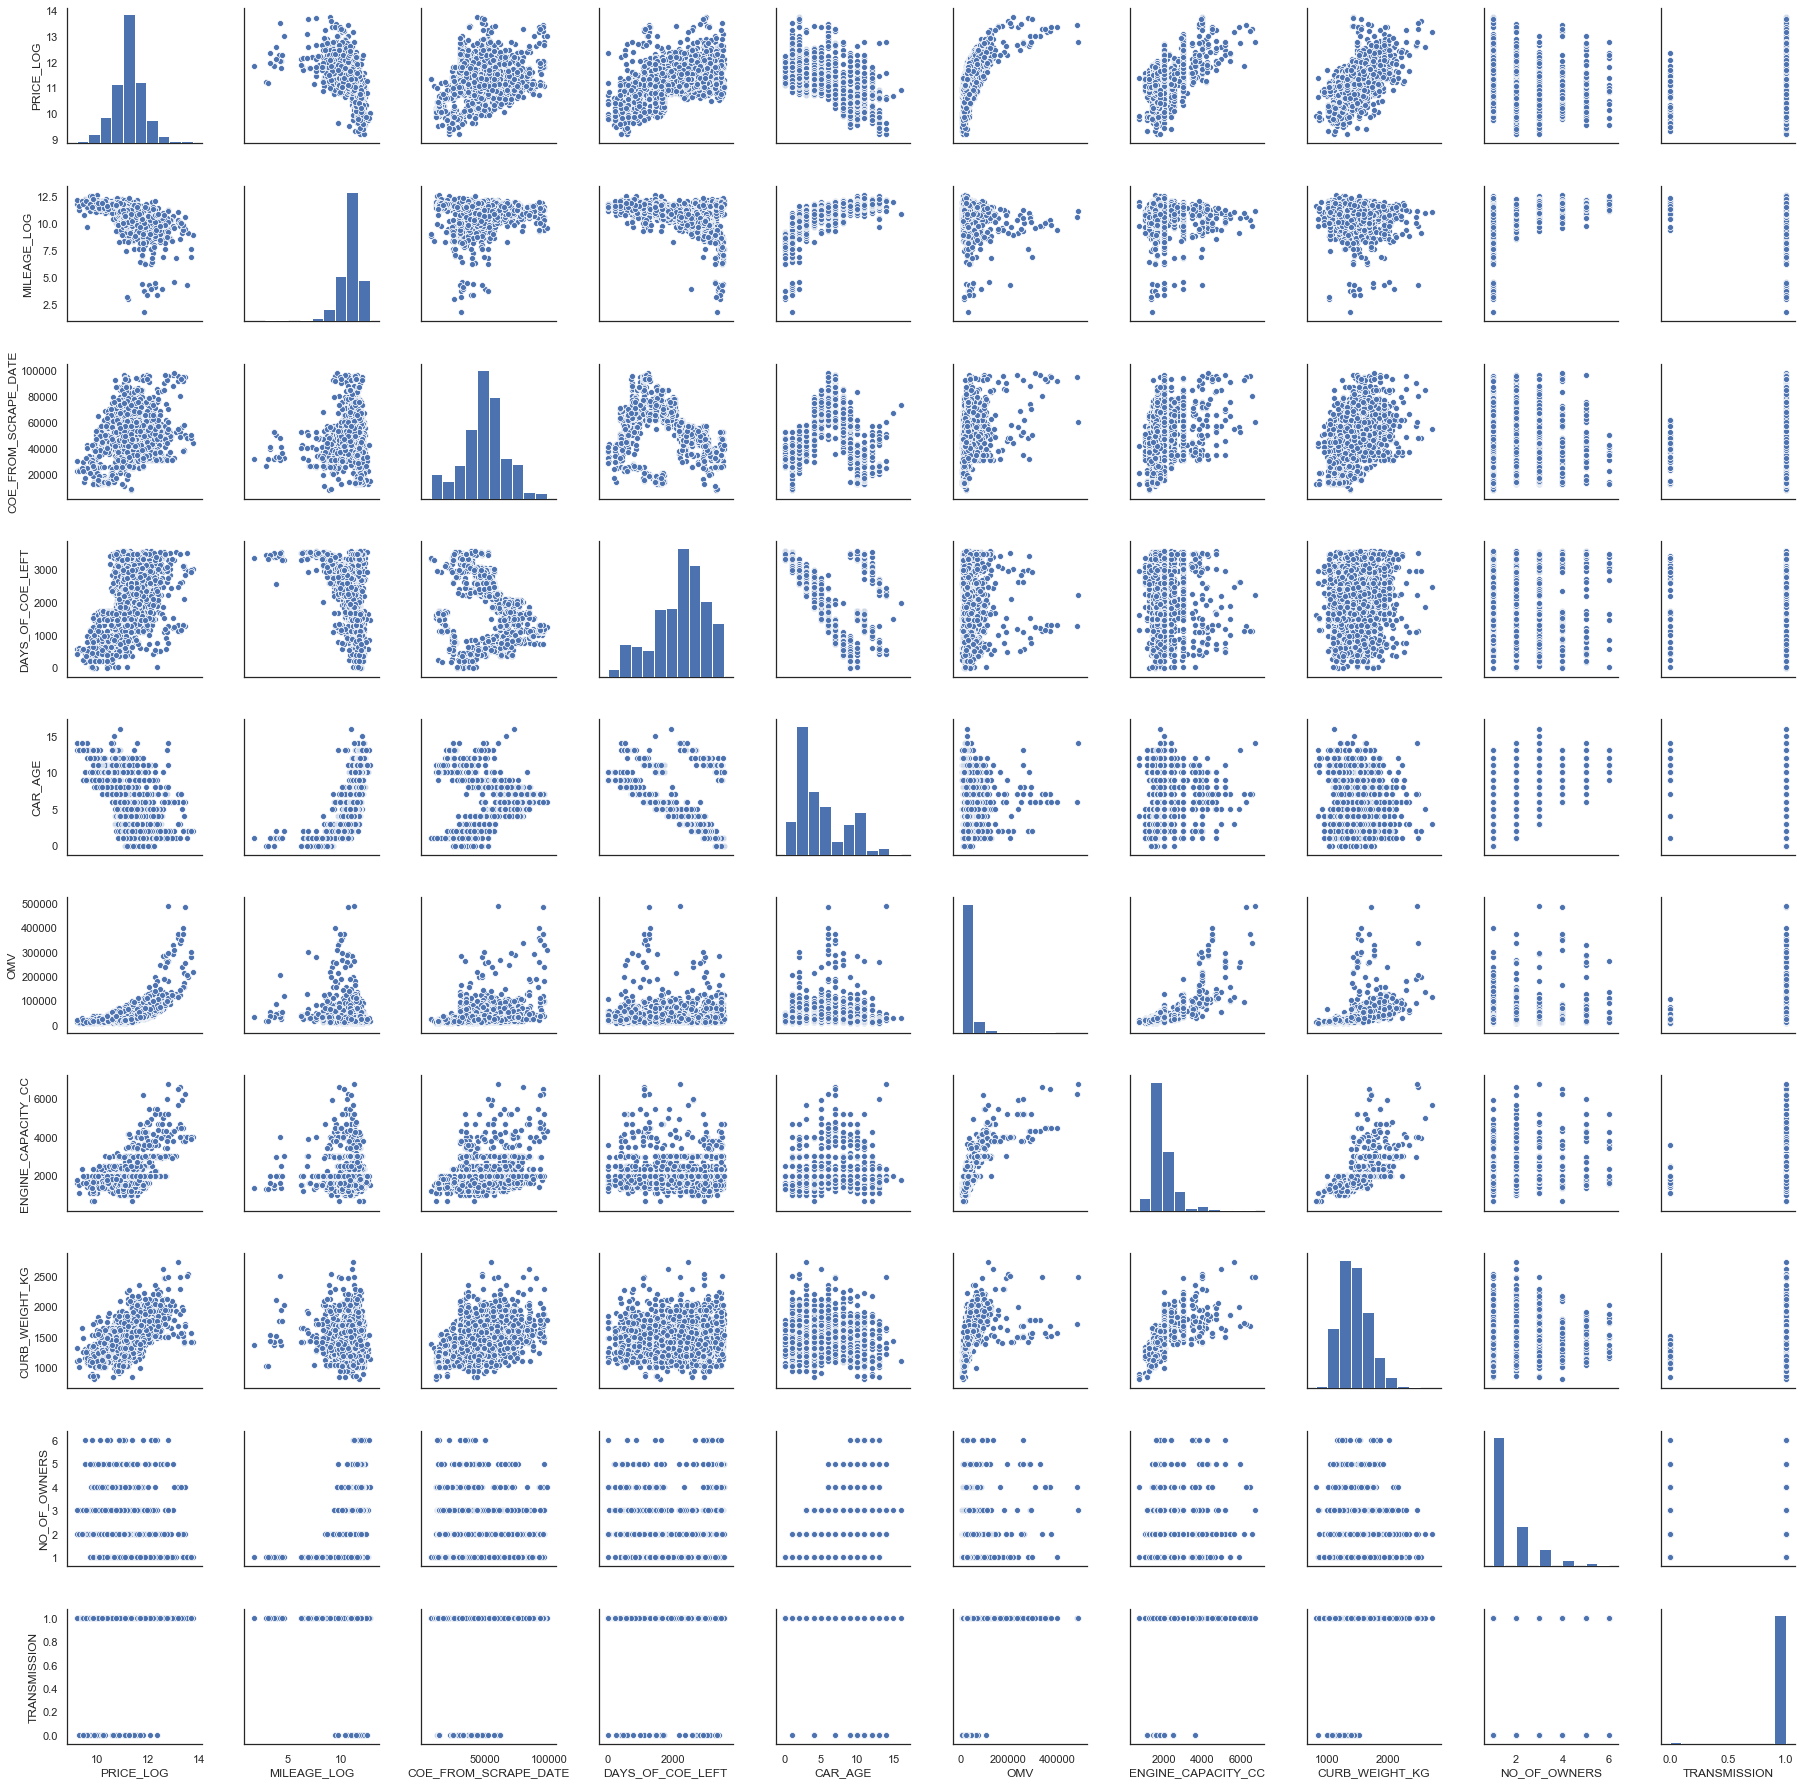

In [83]:
sns.pairplot(df_logged_price_no_brands_only_mileage_logged);
plt.savefig("log_price_and_mileage.png")

In [59]:
# Logging Price
df_logged_price_no_brands_only_mileage_logged['PRICE'] = df_logged_price_no_brands_only_mileage_logged['PRICE'].apply(np.log)

# Renaming column
df_logged_price_no_brands_only_mileage_logged.rename(columns={'PRICE':'PRICE_LOG'},inplace=True)

In [60]:
df_logged_price_no_brands_only_mileage_logged.columns

Index(['PRICE_LOG', 'MILEAGE_LOG', 'COE_FROM_SCRAPE_DATE', 'DAYS_OF_COE_LEFT',
       'CAR_AGE', 'OMV', 'ENGINE_CAPACITY_CC', 'CURB_WEIGHT_KG',
       'NO_OF_OWNERS', 'TRANSMISSION'],
      dtype='object')

In [61]:
df_logged_price_no_brands_only_mileage_logged.head()

PRICE_LOG  MILEAGE_LOG  COE_FROM_SCRAPE_DATE  DAYS_OF_COE_LEFT  CAR_AGE  \
3  11.167614    11.855096               75889.0             761.0      8.0   
4  11.094375    11.669929               39563.0            3503.0     10.0   
5  10.714418    11.744037               41006.0               8.0      9.0   
7  11.167614    10.621327               78810.0            1610.0      6.0   
9  11.401994    10.964467               61103.0            2221.0      4.0   

       OMV  ENGINE_CAPACITY_CC  CURB_WEIGHT_KG  NO_OF_OWNERS  TRANSMISSION  
3  71379.0                2995          2250.0           3.0             1  
4  23465.0                1797          1350.0           2.0             1  
5  56154.0                1796          1650.0           4.0             1  
7  32459.0                1598          1405.0           2.0             1  
9  29913.0                1395          1480.0           2.0             1

In [65]:
# Slicing Data into Independent Variables (Features) and Dependent Variable (Target)
X = df_logged_price_no_brands_only_mileage_logged[['MILEAGE_LOG', 'COE_FROM_SCRAPE_DATE', 'DAYS_OF_COE_LEFT',
       'CAR_AGE', 'OMV', 'ENGINE_CAPACITY_CC', 'CURB_WEIGHT_KG',
       'NO_OF_OWNERS', 'TRANSMISSION'] ].astype(float)
X = sm.add_constant(X)
y = df_logged_price_no_brands_only_mileage_logged['PRICE_LOG'].astype(float)


# model / fit / summarize
import statsmodels.api as sm

lsm = sm.OLS(y, X)
results = lsm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              PRICE_LOG   R-squared:                       0.898
Model:                            OLS   Adj. R-squared:                  0.898
Method:                 Least Squares   F-statistic:                     2530.
Date:                Sun, 03 Nov 2019   Prob (F-statistic):               0.00
Time:                        15:29:33   Log-Likelihood:                 588.71
No. Observations:                2584   AIC:                            -1157.
Df Residuals:                    2574   BIC:                            -1099.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    9.8193      0.070    139.869      0.000       9.682       9.957
MILEAGE_LOG             -0.0280      0.005     -5.129      0.000      -0.039      -0.017
COE_FROM_SCRAPE_DATE  5.823e-06   3.07e-07     18.987      0.000    5.22e-06    6.42e-06
DAYS_OF_COE_LEFT         0.0003   6.51e-06     42.731      0.000       0.000       0.000
CAR_AGE                 -0.0619      0.002    -27.092      0.000      -0.066      -0.057
OMV                    7.22e-06   1.79e-07     40.332      0.000    6.87e-06    7.57e-06
ENGINE_CAPACITY_CC    6.509e-05   1.13e-05      5.752      0.000    4.29e-05    8.73e-05
CURB_WEIGHT_KG           0.0006   2.14e-05     29.225      0.000       0.001       0.001
NO_OF_OWNERS            -0.0052      0.005     -0.956      0.339      -0.016       0.006
TRANSMISSION            -0.1549      0.033     -4.699      0.000      -0.220      -0.090
==============================================================================
Omnibus:                      511.239   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8270.650
Skew:                          -0.467   Prob(JB):                         0.00
Kurtosis:                      11.715   Cond. No.                     1.28e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.28e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### R^2 Summary from Linear Regression Models
Price vs Original Independent Variables:  
R^2: **0.820**  
R^2 Adjusted: **0.820**  
df_price_no_brands
  
Price vs Independent Variables (Logged Mileage and Squared Engine CC):  
R^2: **0.824**  
R^2 Adjusted: **0.824**  
df_price_no_brands_mileage_logged_squared_engine_cap
    
Logged Price vs Independent Variables (Logged Mileage and Squared Engine CC (engine squared became irrelevant):
R^2: **0.897**     
R^2 Adjusted: **0.897**   
df_logged_price_no_brands_mileage_logged_squared_engine_cap
  
Logged Price vs Independent Variables (Logged Mileage):
R^2: **0.898**     
R^2 Adjusted: **0.898**  
df_logged_price_no_brands_only_mileage_logged

## Section 3.3: Analysis of Car Brands, Vehicle Types, Brand Categorization

### 3.3.1: Further breaking down dataframe into finalized features (with log price, log mileage)

In [66]:
df_finalized_features = df_clean2.copy()

In [67]:
# Applying log to the desired features
df_finalized_features['PRICE'] = df_clean2['PRICE'].apply(np.log)
df_finalized_features['MILEAGE'] = df_clean2['MILEAGE_KM'].apply(np.log)


# Renaming features
df_finalized_features.rename(columns={'PRICE':'PRICE_LOG',
                                     'MILEAGE_KM':'MILEAGE_LOG'},inplace=True)

In [68]:
df_finalized_features.columns

Index(['BRAND', 'PRICE_LOG', 'DEPRE_VALUE_PER_YEAR', 'MILEAGE_LOG',
       'COE_FROM_SCRAPE_DATE', 'DAYS_OF_COE_LEFT', 'REG_DATE',
       'MANUFACTURED_YEAR', 'CAR_AGE', 'DEREG_VALUE_FROM_SCRAPE_DATE', 'OMV',
       'ARF', 'ENGINE_CAPACITY_CC', 'ROAD_TAX_PER_YEAR', 'CURB_WEIGHT_KG',
       'NO_OF_OWNERS', 'VEHICLE_TYPE', 'TRANSMISSION', 'Intercept',
       'VEHICLE_TYPE[T.Luxury Sedan]', 'VEHICLE_TYPE[T.MPV]',
       'VEHICLE_TYPE[T.Mid-Sized Sedan]', 'VEHICLE_TYPE[T.SUV]',
       'VEHICLE_TYPE[T.Sports Car]', 'VEHICLE_TYPE[T.Stationwagon]',
       'MILEAGE'],
      dtype='object')

In [69]:
# Rearranging Columns and removing unwanted variables
df_finalized_features = df_finalized_features[['BRAND','PRICE_LOG', 'MILEAGE_LOG', 'COE_FROM_SCRAPE_DATE', 'DAYS_OF_COE_LEFT',
       'CAR_AGE', 'OMV', 'ENGINE_CAPACITY_CC', 'CURB_WEIGHT_KG',
       'NO_OF_OWNERS', 'TRANSMISSION', 'Intercept', 'VEHICLE_TYPE[T.Luxury Sedan]',
       'VEHICLE_TYPE[T.MPV]', 'VEHICLE_TYPE[T.Mid-Sized Sedan]',
       'VEHICLE_TYPE[T.SUV]', 'VEHICLE_TYPE[T.Sports Car]',
       'VEHICLE_TYPE[T.Stationwagon]']]

In [70]:
df_logged_price_no_brands_only_mileage_logged.columns

Index(['PRICE_LOG', 'MILEAGE_LOG', 'COE_FROM_SCRAPE_DATE', 'DAYS_OF_COE_LEFT',
       'CAR_AGE', 'OMV', 'ENGINE_CAPACITY_CC', 'CURB_WEIGHT_KG',
       'NO_OF_OWNERS', 'TRANSMISSION'],
      dtype='object')

In [71]:
df_finalized_features.columns

Index(['BRAND', 'PRICE_LOG', 'MILEAGE_LOG', 'COE_FROM_SCRAPE_DATE',
       'DAYS_OF_COE_LEFT', 'CAR_AGE', 'OMV', 'ENGINE_CAPACITY_CC',
       'CURB_WEIGHT_KG', 'NO_OF_OWNERS', 'TRANSMISSION', 'Intercept',
       'VEHICLE_TYPE[T.Luxury Sedan]', 'VEHICLE_TYPE[T.MPV]',
       'VEHICLE_TYPE[T.Mid-Sized Sedan]', 'VEHICLE_TYPE[T.SUV]',
       'VEHICLE_TYPE[T.Sports Car]', 'VEHICLE_TYPE[T.Stationwagon]'],
      dtype='object')

### 3.3.2: Joining Brand Dummy Variables into Main Dataframe

In [72]:
# Creating a new DataFrame for this Brand Categorization
df_categorized_car_brands = df_finalized_features.copy()

In [73]:
print(df_categorized_car_brands['BRAND'].value_counts())
print(len(df_categorized_car_brands['BRAND'].value_counts()))

Toyota           405
Mercedes-Benz    374
Honda            309
BMW              286
Mazda            139
Nissan           127
Audi             127
Volkswagen       107
Kia               78
Hyundai           77
Volvo             63
Mitsubishi        58
Subaru            56
Porsche           51
Lexus             49
MINI              40
Suzuki            33
Jaguar            22
Citroen           22
Renault           19
Chevrolet         19
Maserati          18
Land Rover        16
Ford              14
Infiniti          14
Peugeot           13
Ferrari           11
Bentley            6
Lamborghini        6
McLaren            5
Opel               4
Jeep               3
Skoda              3
Rolls-Royce        2
Lotus              1
Daihatsu           1
Hummer             1
Ssangyong          1
Aston Martin       1
Fiat               1
Alfa Romeo         1
Proton             1
Name: BRAND, dtype: int64
42


In [74]:
# Creating the relevant columns
df_categorized_car_brands['EXOTIC'] = 0 # Create EXOTIC column
df_categorized_car_brands["ULTRA_LUXURY"] = 0
df_categorized_car_brands["LUXURY"] = 0
df_categorized_car_brands["MID_LEVEL"] = 0
df_categorized_car_brands["ECONOMY"] = 0

In [75]:
# Labelling Car Brands into Exotic
df_categorized_car_brands.loc[(df_clean2['BRAND'] == "Aston Martin") | 
              (df_clean2['BRAND'] == "Ferrari") |
              (df_clean2['BRAND'] == "Lamborghini") |
              (df_clean2['BRAND'] == "McLaren") |
              (df_clean2['BRAND'] == "Hummer"),
              'EXOTIC'] = 1 

# Labelling Car Brands into Ultra Luxury
df_categorized_car_brands.loc[(df_clean2['BRAND'] == "Bentley") | 
              (df_clean2['BRAND'] == "Land Rover") |
              (df_clean2['BRAND'] == "Maserati") |
              (df_clean2['BRAND'] == "Porsche") |
              (df_clean2['BRAND'] == "Rolls-Royce"), 
              "ULTRA_LUXURY"] = 1 

# Labelling Car Brands into Luxury

df_categorized_car_brands.loc[(df_clean2['BRAND'] == "Audi") | 
              (df_clean2['BRAND'] == "BMW") |
              (df_clean2['BRAND'] == "Jeep") |
              (df_clean2['BRAND'] == "Lexus") |
              (df_clean2['BRAND'] == "Lotus") |
              (df_clean2['BRAND'] == "Mercedes-Benz") |
              (df_clean2['BRAND'] == "Volvo") |
              (df_clean2['BRAND'] == "Peugeot"), 
              "LUXURY"] = 1 


# Labelling Car Brands into Mid-Level

df_categorized_car_brands.loc[(df_clean2['BRAND'] == "Infiniti") |
              (df_clean2['BRAND'] == "MINI") |
              (df_clean2['BRAND'] == "Volkswagen") |
              (df_clean2['BRAND'] == "Renault") |
              (df_clean2['BRAND'] == "Peugeot"), 
              "MID_LEVEL"] = 1 

# (df_clean2['BRAND'] == "Opel") & "Alfa Romeo" will be considered as "Others" because it is not a very common brand in Singapore

# Labelling Car Brands into Economy

df_categorized_car_brands.loc[(df_clean2['BRAND'] == "Chevrolet") | 
              (df_clean2['BRAND'] == "Citroen") |
              (df_clean2['BRAND'] == "Ford") |
              (df_clean2['BRAND'] == "Honda") |
              (df_clean2['BRAND'] == "Hyundai") |
              (df_clean2['BRAND'] == "Kia") |
              (df_clean2['BRAND'] == "Mazda") |
              (df_clean2['BRAND'] == "Mitsubishi") |
              (df_clean2['BRAND'] == "Nissan") |
              (df_clean2['BRAND'] == "Suzuki") |
              (df_clean2['BRAND'] == "Toyota"),
              "ECONOMY"] = 0

# (df_clean2['BRAND'] == "Ssangyong") will be considered as "Others" because it is not a common brand in Singapore


# The rest of the car brands not in these categories will be considered Budget
df_categorized_car_brands["BUDGET"] = 0
df_categorized_car_brands.loc[(df_clean2['BRAND'] == 'Opel') |
              (df_clean2['BRAND'] == 'Ssangyong') |
              (df_clean2['BRAND'] == 'Proton') |
              (df_clean2['BRAND'] == 'Daihatsu') |
              (df_clean2['BRAND'] == 'Fiat') |
              (df_clean2['BRAND'] == 'Alfa Romeo') |
              (df_clean2['BRAND'] == 'Skoda'), 
              'BUDGET'] = 1 

# Changing Uncommon Car brands to "Others"
df_categorized_car_brands.loc[(df_clean2['BRAND'] == 'Opel') |
                  (df_clean2['BRAND'] == 'Ssangyong') |
                  (df_clean2['BRAND'] == 'Proton') |
                  (df_clean2['BRAND'] == 'Daihatsu') |
                  (df_clean2['BRAND'] == 'Fiat') |
                  (df_clean2['BRAND'] == 'Alfa Romeo') |
                  (df_clean2['BRAND'] == 'Skoda') |
                  (df_clean2['BRAND'] == 'Hummer')|
                  (df_clean2['BRAND'] == 'Aston Martin')|
                  (df_clean2['BRAND'] == 'Lotus')|
                  (df_clean2['BRAND'] == 'Ford')|
                  (df_clean2['BRAND'] == 'Jeep'), 
                  'BRAND'] = "Others"


# Group uncommon cars into "Others". There are too many brands to work with.

In [76]:
print(df_categorized_car_brands['BRAND'].value_counts())
print(len(df_categorized_car_brands['BRAND'].value_counts()))

Toyota           405
Mercedes-Benz    374
Honda            309
BMW              286
Mazda            139
Audi             127
Nissan           127
Volkswagen       107
Kia               78
Hyundai           77
Volvo             63
Mitsubishi        58
Subaru            56
Porsche           51
Lexus             49
MINI              40
Suzuki            33
Others            32
Citroen           22
Jaguar            22
Renault           19
Chevrolet         19
Maserati          18
Land Rover        16
Infiniti          14
Peugeot           13
Ferrari           11
Lamborghini        6
Bentley            6
McLaren            5
Rolls-Royce        2
Name: BRAND, dtype: int64
31


##### Brand Dummy Variables Creation

In [77]:
x_brand_dummy = patsy.dmatrix('BRAND', data=df_categorized_car_brands, return_type='dataframe')
x_brand_dummy.head()

Intercept  BRAND[T.BMW]  BRAND[T.Bentley]  BRAND[T.Chevrolet]  \
3        1.0           0.0               0.0                 0.0   
4        1.0           0.0               0.0                 0.0   
5        1.0           0.0               0.0                 0.0   
7        1.0           1.0               0.0                 0.0   
9        1.0           0.0               0.0                 0.0   

   BRAND[T.Citroen]  BRAND[T.Ferrari]  BRAND[T.Honda]  BRAND[T.Hyundai]  \
3               0.0               0.0             0.0               0.0   
4               0.0               0.0             0.0               0.0   
5               0.0               0.0             0.0               0.0   
7               0.0               0.0             0.0               0.0   
9               0.0               0.0             0.0               0.0   

   BRAND[T.Infiniti]  BRAND[T.Jaguar]  ...  BRAND[T.Others]  BRAND[T.Peugeot]  \
3                0.0              0.0  ...              0.0               0.0   
4                0.0              0.0  ...              0.0               0.0   
5                0.0              0.0  ...              0.0               0.0   
7                0.0              0.0  ...              0.0               0.0   
9                0.0              0.0  ...              0.0               0.0   

   BRAND[T.Porsche]  BRAND[T.Renault]  BRAND[T.Rolls-Royce]  BRAND[T.Subaru]  \
3               0.0               0.0                   0.0              0.0   
4               0.0               0.0                   0.0              0.0   
5               0.0               0.0                   0.0              0.0   
7               0.0               0.0                   0.0              0.0   
9               0.0               0.0                   0.0              0.0   

   BRAND[T.Suzuki]  BRAND[T.Toyota]  BRAND[T.Volkswagen]  BRAND[T.Volvo]  
3              0.0              0.0                  0.0             0.0  
4              0.0              1.0                  0.0             0.0  
5              0.0              0.0                  0.0             0.0  
7              0.0              0.0                  0.0             0.0  
9              0.0              0.0                  0.0             0.0  

[5 rows x 31 columns]

In [78]:
df_categorized_car_brands.drop('Intercept',axis=1,inplace=True)# Drop intercept because already have intercept from previous vehicle type
df_categorized_car_brands = df_categorized_car_brands.join(x_brand_dummy)
df_categorized_car_brands

BRAND  PRICE_LOG  MILEAGE_LOG  COE_FROM_SCRAPE_DATE  \
3              Audi  11.167614     140800.0               75889.0   
4            Toyota  11.094375     117000.0               39563.0   
5     Mercedes-Benz  10.714418     126000.0               41006.0   
7               BMW  11.167614      41000.0               78810.0   
9              Audi  11.401994      57784.0               61103.0   
...             ...        ...          ...                   ...   
3981  Mercedes-Benz  11.550221      19000.0               53694.0   
3982         Toyota  11.556942      47638.0               84504.0   
3983  Mercedes-Benz  11.652687      51500.0               67901.0   
3984           MINI  11.693579      16000.0               53300.0   
3985         Nissan  11.312033      53339.0               57501.0   

      DAYS_OF_COE_LEFT  CAR_AGE      OMV  ENGINE_CAPACITY_CC  CURB_WEIGHT_KG  \
3                761.0      8.0  71379.0                2995          2250.0   
4               3503.0     10.0  23465.0                1797          1350.0   
5                  8.0      9.0  56154.0                1796          1650.0   
7               1610.0      6.0  32459.0                1598          1405.0   
9               2221.0      4.0  29913.0                1395          1480.0   
...                ...      ...      ...                 ...             ...   
3981            2434.0      3.0  27886.0                1595          1430.0   
3982            1679.0      5.0  45977.0                3456          2030.0   
3983            1950.0      7.0  52051.0                1796          1600.0   
3984            2769.0      2.0  33570.0                1998          1390.0   
3985            2462.0      4.0  26629.0                2488          1510.0   

      NO_OF_OWNERS  ...  BRAND[T.Others]  BRAND[T.Peugeot]  BRAND[T.Porsche]  \
3              3.0  ...              0.0               0.0               0.0   
4              2.0  ...              0.0               0.0               0.0   
5              4.0  ...              0.0               0.0               0.0   
7              2.0  ...              0.0               0.0               0.0   
9              2.0  ...              0.0               0.0               0.0   
...            ...  ...              ...               ...               ...   
3981           1.0  ...              0.0               0.0               0.0   
3982           2.0  ...              0.0               0.0               0.0   
3983           2.0  ...              0.0               0.0               0.0   
3984           1.0  ...              0.0               0.0               0.0   
3985           1.0  ...              0.0               0.0               0.0   

      BRAND[T.Renault]  BRAND[T.Rolls-Royce]  BRAND[T.Subaru]  \
3                  0.0                   0.0              0.0   
4                  0.0                   0.0              0.0   
5                  0.0                   0.0              0.0   
7                  0.0                   0.0              0.0   
9                  0.0                   0.0              0.0   
...                ...                   ...              ...   
3981               0.0                   0.0              0.0   
3982               0.0                   0.0              0.0   
3983               0.0                   0.0              0.0   
3984               0.0                   0.0              0.0   
3985               0.0                   0.0              0.0   

      BRAND[T.Suzuki]  BRAND[T.Toyota]  BRAND[T.Volkswagen]  BRAND[T.Volvo]  
3                 0.0              0.0                  0.0             0.0  
4                 0.0              1.0                  0.0             0.0  
5                 0.0              0.0                  0.0             0.0  
7                 0.0              0.0                  0.0             0.0  
9                 0.0              0.0                  0.0             0.0  
...           

### 3.3.4 : Only Brand Segregation

In [79]:
df_categorized_car_brands.columns

Index(['BRAND', 'PRICE_LOG', 'MILEAGE_LOG', 'COE_FROM_SCRAPE_DATE',
       'DAYS_OF_COE_LEFT', 'CAR_AGE', 'OMV', 'ENGINE_CAPACITY_CC',
       'CURB_WEIGHT_KG', 'NO_OF_OWNERS', 'TRANSMISSION',
       'VEHICLE_TYPE[T.Luxury Sedan]', 'VEHICLE_TYPE[T.MPV]',
       'VEHICLE_TYPE[T.Mid-Sized Sedan]', 'VEHICLE_TYPE[T.SUV]',
       'VEHICLE_TYPE[T.Sports Car]', 'VEHICLE_TYPE[T.Stationwagon]', 'EXOTIC',
       'ULTRA_LUXURY', 'LUXURY', 'MID_LEVEL', 'ECONOMY', 'BUDGET', 'Intercept',
       'BRAND[T.BMW]', 'BRAND[T.Bentley]', 'BRAND[T.Chevrolet]',
       'BRAND[T.Citroen]', 'BRAND[T.Ferrari]', 'BRAND[T.Honda]',
       'BRAND[T.Hyundai]', 'BRAND[T.Infiniti]', 'BRAND[T.Jaguar]',
       'BRAND[T.Kia]', 'BRAND[T.Lamborghini]', 'BRAND[T.Land Rover]',
       'BRAND[T.Lexus]', 'BRAND[T.MINI]', 'BRAND[T.Maserati]',
       'BRAND[T.Mazda]', 'BRAND[T.McLaren]', 'BRAND[T.Mercedes-Benz]',
       'BRAND[T.Mitsubishi]', 'BRAND[T.Nissan]', 'BRAND[T.Others]',
       'BRAND[T.Peugeot]', 'BRAND[T.Porsche]', 'BRAND

In [80]:
df_categorized_car_brands[['MILEAGE_LOG', 'COE_FROM_SCRAPE_DATE',
       'DAYS_OF_COE_LEFT', 'CAR_AGE', 'OMV', 'ENGINE_CAPACITY_CC',
       'CURB_WEIGHT_KG', 'NO_OF_OWNERS', 'TRANSMISSION', 'EXOTIC', 'ULTRA_LUXURY', 'LUXURY',
       'MID_LEVEL', 'ECONOMY', 'BUDGET']]

MILEAGE_LOG  COE_FROM_SCRAPE_DATE  DAYS_OF_COE_LEFT  CAR_AGE      OMV  \
3        140800.0               75889.0             761.0      8.0  71379.0   
4        117000.0               39563.0            3503.0     10.0  23465.0   
5        126000.0               41006.0               8.0      9.0  56154.0   
7         41000.0               78810.0            1610.0      6.0  32459.0   
9         57784.0               61103.0            2221.0      4.0  29913.0   
...           ...                   ...               ...      ...      ...   
3981      19000.0               53694.0            2434.0      3.0  27886.0   
3982      47638.0               84504.0            1679.0      5.0  45977.0   
3983      51500.0               67901.0            1950.0      7.0  52051.0   
3984      16000.0               53300.0            2769.0      2.0  33570.0   
3985      53339.0               57501.0            2462.0      4.0  26629.0   

      ENGINE_CAPACITY_CC  CURB_WEIGHT_KG  NO_OF_OWNERS  TRANSMISSION  EXOTIC  \
3                   2995          2250.0           3.0             1       0   
4                   1797          1350.0           2.0             1       0   
5                   1796          1650.0           4.0             1       0   
7                   1598          1405.0           2.0             1       0   
9                   1395          1480.0           2.0             1       0   
...                  ...             ...           ...           ...     ...   
3981                1595          1430.0           1.0             1       0   
3982                3456          2030.0           2.0             1       0   
3983                1796          1600.0           2.0             1       0   
3984                1998          1390.0           1.0             1       0   
3985                2488          1510.0           1.0             1       0   

      ULTRA_LUXURY  LUXURY  MID_LEVEL  ECONOMY  BUDGET  
3                0       1          0        0       0  
4                0       0          0        0       0  
5                0       1          0        0       0  
7                0       1          0        0       0  
9                0       1          0        0       0  
...            ...     ...        ...      ...     ...  
3981             0       1          0        0       0  
3982             0       0          0        0       0  
3983             0       1          0        0       0  
3984             0       0          1        0       0  
3985             0       0          0        0       0  

[2584 rows x 15 columns]

In [81]:
# Finding out new R^2 from log transformations of Log Price and Log Independent Variables (except Mileage)

# Slicing Variables
X = df_categorized_car_brands[['MILEAGE_LOG', 'COE_FROM_SCRAPE_DATE',
       'DAYS_OF_COE_LEFT', 'CAR_AGE', 'OMV', 'ENGINE_CAPACITY_CC',
       'CURB_WEIGHT_KG', 'NO_OF_OWNERS', 'TRANSMISSION', 'EXOTIC', 'ULTRA_LUXURY', 'LUXURY',
       'MID_LEVEL', 'ECONOMY', 'BUDGET']]
X = sm.add_constant(X)
y = df_categorized_car_brands['PRICE_LOG']

# Initially my coefficients were difficult to interpret. 
# Therefore I transformed it using log for better explanation purposes

# model / fit / summarize
import statsmodels.api as sm

lsm = sm.OLS(y, X)
results = lsm.fit()
results.summary()

C:\Users\xianj\Anaconda3\envs\metis\lib\site-packages\statsmodels\regression\linear_model.py:1755: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
C:\Users\xianj\Anaconda3\envs\metis\lib\site-packages\statsmodels\base\model.py:1294: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
C:\Users\xianj\Anaconda3\envs\metis\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\xianj\Anaconda3\envs\metis\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\xianj\Anaconda3\envs\metis\lib\site-packages\scipy\stats\_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              PRICE_LOG   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.920
Method:                 Least Squares   F-statistic:                     2135.
Date:                Sun, 03 Nov 2019   Prob (F-statistic):               0.00
Time:                        15:29:35   Log-Likelihood:                 911.29
No. Observations:                2584   AIC:                            -1793.
Df Residuals:                    2569   BIC:                            -1705.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    9.7421      0.043    224.613      0.000       9.657       9.827
MILEAGE_LOG          -7.627e-07    1.5e-07     -5.078      0.000   -1.06e-06   -4.68e-07
COE_FROM_SCRAPE_DATE  4.544e-06   2.64e-07     17.214      0.000    4.03e-06    5.06e-06
DAYS_OF_COE_LEFT         0.0003   5.81e-06     48.698      0.000       0.000       0.000
CAR_AGE                 -0.0581      0.002    -25.365      0.000      -0.063      -0.054
OMV                   6.382e-06   2.31e-07     27.678      0.000    5.93e-06    6.83e-06
ENGINE_CAPACITY_CC       0.0001   1.07e-05     11.495      0.000       0.000       0.000
CURB_WEIGHT_KG           0.0004   2.11e-05     20.029      0.000       0.000       0.000
NO_OF_OWNERS            -0.0110      0.005     -2.249      0.025      -0.021      -0.001
TRANSMISSION            -0.1641      0.029     -5.632      0.000      -0.221      -0.107
EXOTIC                  -0.0389      0.060     -0.648      0.517      -0.157       0.079
ULTRA_LUXURY             0.2656      0.023     11.303      0.000       0.220       0.312
LUXURY                   0.2156      0.009     24.415      0.000       0.198       0.233
MID_LEVEL                0.0834      0.013      6.216      0.000       0.057       0.110
ECONOMY                       0          0        nan        nan           0           0
BUDGET                  -0.0045      0.050     -0.091      0.927      -0.102       0.093
==============================================================================
Omnibus:                      584.846   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12703.299
Skew:                          -0.518   Prob(JB):                         0.00
Kurtosis:                      13.813   Cond. No.                          inf
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is      0. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

### R^2 Summary from Linear Regression Models
Price vs Original Independent Variables:  
R^2: **0.820**  
R^2 Adjusted: **0.820**  
df_price_no_brands
  
Price vs Independent Variables (Logged Mileage and Squared Engine CC):  
R^2: **0.824**  
R^2 Adjusted: **0.824**  
df_price_no_brands_mileage_logged_squared_engine_cap
    
Logged Price vs Independent Variables (Logged Mileage and Squared Engine CC (engine squared became irrelevant):
R^2: **0.897**     
R^2 Adjusted: **0.897**   
df_logged_price_no_brands_mileage_logged_squared_engine_cap
  
Logged Price vs Independent Variables (Logged Mileage):
R^2: **0.898**     
R^2 Adjusted: **0.898**  
df_logged_price_no_brands_only_mileage_logged  
  
Logged Price vs Independent Variables (Logged Mileage) + Categorized Car Brands:
R^2: **0.921**     
R^2 Adjusted: **0.921**  
df_categorized_car_brands

## Section 4.2: Cross-Validation Using Models other than LR

### Section 4.2.1 : Using LassoCV to find best Alpha Value for L1 Regularization

In [231]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

In [232]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold  #Kfold will allow you to do cross validation

X = df_categorized_car_brands[['MILEAGE_LOG', 'COE_FROM_SCRAPE_DATE',
       'DAYS_OF_COE_LEFT', 'CAR_AGE', 'OMV', 'ENGINE_CAPACITY_CC',
       'CURB_WEIGHT_KG', 'NO_OF_OWNERS', 'TRANSMISSION', 'EXOTIC', 'ULTRA_LUXURY', 'LUXURY',
       'MID_LEVEL', 'ECONOMY', 'BUDGET']]

y = df_categorized_car_brands['PRICE_LOG']

# hold out 20% of the data for final testing

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = 0.2, random_state=10)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.2, random_state=20)

In [233]:

## Scale the data (a MUST if you're doing regularization)
std = StandardScaler()
std.fit(X_train.values)

## Scale the Predictors on both the train/validation (the whole 80%) and test set (the whole 20%)
X_train_scaled = std.transform(X_train.values)
X_val_scaled = std.transform(X_val.values)

# LassoCV does 2 things for you. It trains your model, and it also chooses the best lambda/alpha for you.  
# But of course, you have to feed it a list of lambdas to try.

# The best part about LambdaCV is that it does all 3 for you:
# Fit
# Finding best lambda
# Doing Cross-Validation

from sklearn.model_selection import KFold   #Kfold will allow you to do cross validation

# Run the cross validation, find the best alpha, refit the model on all the data with that alpha

alphavec = 10**np.linspace(-3,3,200) # Defining a vector of lambdas (alpha) to try from
kf = KFold(n_splits=5, shuffle=True, random_state = 1000)  # Creating a partitioned randomized-state data

lasso_model = LassoCV(alphas = alphavec, cv=kf)  # If you want to use Ridge, use RidgeCV
lasso_model.fit(X_train_scaled, y_train)

# This is the best alpha value it found - not far from the value
# selected using simple validation
lasso_model.alpha_

0.0032550885998350564

In [234]:
# These are the (standardized) coefficients found when it refit using that best alpha
list(zip(X_train.columns, lasso_model.coef_))

[('MILEAGE_LOG', -0.03689110265680966),
 ('COE_FROM_SCRAPE_DATE', 0.06481376606248887),
 ('DAYS_OF_COE_LEFT', 0.21812096373130438),
 ('CAR_AGE', -0.17695678924170913),
 ('OMV', 0.26330195415653385),
 ('ENGINE_CAPACITY_CC', 0.06969015644788246),
 ('CURB_WEIGHT_KG', 0.10542852759678789),
 ('NO_OF_OWNERS', -0.010508119632416752),
 ('TRANSMISSION', -0.02332597379628407),
 ('EXOTIC', -0.02889039617933594),
 ('ULTRA_LUXURY', 0.0328461338537053),
 ('LUXURY', 0.05758408083998944),
 ('MID_LEVEL', 0.0),
 ('ECONOMY', -0.04142286228425683),
 ('BUDGET', -0.0)]

In [238]:
def RMSE(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

# Make predictions on the test set using the new model 
# (the model is already using the best alpha. It is a LassoCV initialization)
val_set_pred = lasso_model.predict(X_val_scaled)

# Find the MAE and R^2 on the test set using this model
print(f"LassoCV Best Lambda (alpha): {lasso_model.alpha_}")
print(f"LassoCV RMSE: {RMSE(y_val, val_set_pred)}")
print(f"LassoCV R^2 Score: {r2_score(y_val, val_set_pred)}")

LassoCV Best Lambda (alpha): 0.0032550885998350564
LassoCV RMSE: 0.2060456832969135
LassoCV R^2 Score: 0.8908070012251001


### Section 4.2.2: Using RidgeCV to find best Alpha Value for L2 Regularization

In [239]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures


from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold  #Kfold will allow you to do cross validation

X = df_categorized_car_brands[['MILEAGE_LOG', 'COE_FROM_SCRAPE_DATE',
       'DAYS_OF_COE_LEFT', 'CAR_AGE', 'OMV', 'ENGINE_CAPACITY_CC',
       'CURB_WEIGHT_KG', 'NO_OF_OWNERS', 'TRANSMISSION', 'EXOTIC', 'ULTRA_LUXURY', 'LUXURY',
       'MID_LEVEL', 'ECONOMY', 'BUDGET']]

y = df_categorized_car_brands['PRICE_LOG']

# hold out 20% of the data for final testing

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = 0.2, random_state=10)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.2, random_state=20)

In [240]:
# Use RidgeCV to find the optimal ALPHA value for L2 regularization

## Scale the data (a MUST if you're doing regularization)
std = StandardScaler()
std.fit(X_train.values)

# Scale the Predictors on both the train and validation set (for RidgeCV)
X_train_scaled = std.transform(X_train.values)
X_val_scaled = std.transform(X_val.values)

# Run the cross-validation, find the best alpha, refit the model on all the data with that alpha (RidgeCV does this for you)
alphavec = 10 ** np.linspace(-3,3,200) # alpha varies from 0.001 to 1000
kf = KFold(n_splits=5, shuffle=True, random_state=1000)

ridge_model = RidgeCV(alphas=alphavec, cv=kf)
ridge_model.fit(X_train_scaled, y_train)  # Fit your scaled train input and your y train values

# This is the best alpha value found
ridge_model.alpha_

21.96385372416547

In [241]:
# display all coefficients in the model with optimal alpha
list(zip(X_train.columns, ridge_model.coef_))

[('MILEAGE_LOG', -0.042394292256485146),
 ('COE_FROM_SCRAPE_DATE', 0.06678341343292019),
 ('DAYS_OF_COE_LEFT', 0.21841575383069542),
 ('CAR_AGE', -0.1716508933134741),
 ('OMV', 0.2577164568452119),
 ('ENGINE_CAPACITY_CC', 0.07655344165346685),
 ('CURB_WEIGHT_KG', 0.10350971130241264),
 ('NO_OF_OWNERS', -0.014649744302495105),
 ('TRANSMISSION', -0.027096576516797567),
 ('EXOTIC', -0.029496516213225302),
 ('ULTRA_LUXURY', 0.037397703001438846),
 ('LUXURY', 0.06504754305742101),
 ('MID_LEVEL', 0.004835938074657496),
 ('ECONOMY', -0.037328614642465174),
 ('BUDGET', -0.0003095576440478138)]

In [242]:
def RMSE(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

# Make predictions on the test set using the new model and save it into a variable
val_set_pred = lasso_model.predict(X_val_scaled)


# Find the MAE and R^2 on the test set using this model
print(f"Best Lambda (alpha) RidgeCV: {ridge_model.alpha_}")
print(f"RidgeCV MAE: {RMSE(y_val, val_set_pred)}")
print(f"RidgeCV R^2 Score: {r2_score(y_val, val_set_pred)}")

Best Lambda (alpha) RidgeCV: 21.96385372416547
RidgeCV MAE: 0.2060456832969135
RidgeCV R^2 Score: 0.8908070012251001


### Section 4.2.3: Using ElasticnetCV to find best Alpha Value 

In [244]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures


from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold  #Kfold will allow you to do cross validation

X = df_categorized_car_brands[['MILEAGE_LOG', 'COE_FROM_SCRAPE_DATE',
       'DAYS_OF_COE_LEFT', 'CAR_AGE', 'OMV', 'ENGINE_CAPACITY_CC',
       'CURB_WEIGHT_KG', 'NO_OF_OWNERS', 'TRANSMISSION', 'EXOTIC', 'ULTRA_LUXURY', 'LUXURY',
       'MID_LEVEL', 'ECONOMY', 'BUDGET']]

y = df_categorized_car_brands['PRICE_LOG']

# hold out 20% of the data for final testing

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = 0.2, random_state=10)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.2, random_state=20)

In [245]:
# Using ElasticNetCV to find the optimal ALPHA value
# Scale the data as before (scaling is a must for regularization)
std = StandardScaler()
std.fit(X_train.values) # (60% of the data)

# Scale the Predictors on both the train and validation set
X_train_scaled = std.transform(X_train.values)
X_val_scalred = std.transform(X_val.values)

# Run the cross-validation, find the best alpha, refit the model and all the data using that alpha (ElasticNetCV does this for you)
alphavec = 10 ** np.linspace(-3,3,200)  # alpha varies from 0.001 to 1000
kf = KFold(n_splits=5, shuffle=True, random_state=1000)

elasticnet_model = ElasticNetCV(alphas = alphavec, cv=kf)
elasticnet_model.fit(X_train_scaled, y_train)  # Fitting standardscaled input and true y values into model to train it

elasticnet_model.alpha_

0.006080224261649421

In [246]:
# display all coefficients in the model with optimal alpha
list(zip(X_train.columns, elasticnet_model.coef_))

[('MILEAGE_LOG', -0.03837190175452888),
 ('COE_FROM_SCRAPE_DATE', 0.06478560224721128),
 ('DAYS_OF_COE_LEFT', 0.2174561074427263),
 ('CAR_AGE', -0.17563704481132553),
 ('OMV', 0.25958740349987547),
 ('ENGINE_CAPACITY_CC', 0.07126100701743189),
 ('CURB_WEIGHT_KG', 0.10532508487078017),
 ('NO_OF_OWNERS', -0.010911873656657658),
 ('TRANSMISSION', -0.023449556858663432),
 ('EXOTIC', -0.027156002700613833),
 ('ULTRA_LUXURY', 0.03365270850201948),
 ('LUXURY', 0.058052096561623016),
 ('MID_LEVEL', 0.0),
 ('ECONOMY', -0.0418436736583076),
 ('BUDGET', -0.0)]

In [247]:
def RMSE(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

# Use this model to do prediction on a validation data set
val_set_pred = elasticnet_model.predict(X_val_scaled)

# Find the MAE and R^2 on the test set using this model
print(f'Best Lambda (Alpha) ElasticNetCV: {elasticnet_model.alpha_}')
print(f'ElasticNetCV RMSE: {RMSE(y_val, val_set_pred)}')  # mae is a defined function above
print(f'ElasticNetCV R^2 Score: {r2_score(y_val, val_set_pred)}')  # r2_score is an imported module

Best Lambda (Alpha) ElasticNetCV: 0.006080224261649421
ElasticNetCV RMSE: 0.20546000914492651
ElasticNetCV R^2 Score: 0.8914268698533193


### Section 4.2.3: Summary from the above Train-Validation Sets

LassoCV Best Lambda (alpha): 0.0032550885998350564  
LassoCV RMSE: 0.2060456832969135  
LassoCV R^2 Score: 0.8908070012251001  
  
Best Lambda (alpha) RidgeCV: 21.96385372416547  
RidgeCV MAE: 0.2060456832969135  
RidgeCV R^2 Score: 0.8908070012251001  
  
Best Lambda (Alpha) ElasticNetCV: 0.006080224261649421  
ElasticNetCV RMSE: 0.20546000914492651    
ElasticNetCV R^2 Score: 0.8914268698533193  

### Section 4.3: Picking Model with the best R^2 score (Train and Cross-Validation)

In [251]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures


from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold  #Kfold will allow you to do cross validation

X = df_categorized_car_brands[['MILEAGE_LOG', 'COE_FROM_SCRAPE_DATE',
       'DAYS_OF_COE_LEFT', 'CAR_AGE', 'OMV', 'ENGINE_CAPACITY_CC',
       'CURB_WEIGHT_KG', 'NO_OF_OWNERS', 'TRANSMISSION', 'EXOTIC', 'ULTRA_LUXURY', 'LUXURY',
       'MID_LEVEL', 'ECONOMY', 'BUDGET']]

y = df_categorized_car_brands['PRICE_LOG']

# Create 80% of train data. The code below will automate the cross-validation
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = 0.2, random_state=10)

In [252]:
## cross validation using KFold (on the 100% dataset, without manually splitting)
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

def RMSE(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))


#Feature transform/scaling so that we can run our ridge/lasso/elasticnet model 
scaler = StandardScaler()
X_train_val_scaled = scaler.fit_transform(X_train_val.values)

#Feature transform/scaling so that we can run our poly model 
poly = PolynomialFeatures(degree=2) 
X_train_val_poly = poly.fit_transform(X_train_val.values)

kf = KFold(n_splits=5, shuffle=True, random_state = 1000)

lm = LinearRegression()
cvs_lm = cross_val_score(lm, X_train_val, y_train_val, cv=kf, scoring='r2')
print("Linear Regression Cross Val Score: {}".format(cvs_lm))
# print(f'ElasticNetCV RMSE: {round(RMSE(y_val, val_set_pred),3)}')
print('Linear regression cv R^2:', round(np.mean(cvs_lm),3), '+-', round(np.std(cvs_lm),3),'\n' )


lm_ridge = Ridge(alpha=21.96385372416547 )
cvs_ridge = cross_val_score(lm_ridge, X_train_val_scaled, y_train_val, cv=kf, scoring='r2')
print("Ridge Cross Val Score: {}".format(cvs_ridge))
# print(f'ElasticNetCV RMSE: {round(RMSE(y_val, val_set_pred),3)}')
print('Ridge regression cv R^2:', round(np.mean(cvs_ridge),3), '+-', round(np.std(cvs_ridge),3),'\n' )



lm_lasso = Lasso(alpha=0.0032550885998350564)
cvs_lasso = cross_val_score(lm_lasso, X_train_val_scaled, y_train_val, cv=kf, scoring='r2')
print("Lasso Cross Val Score: {}".format(cvs_lasso))
# print(f'ElasticNetCV RMSE: {round(RMSE(y_val, val_set_pred),3)}')
print('Lasso regression cv R^2:', round(np.mean(cvs_lasso),3), '+-', round(np.std(cvs_lasso),3),'\n' )


lm_elasticnet = ElasticNet(alpha=0.006080224261649421 )
cvs_elasticnet = cross_val_score(lm_elasticnet, X_train_val_scaled, y_train_val, cv=kf, scoring='r2')
print("Elastic Net Cross Val Score: {}".format(cvs_elasticnet))
# print(f'ElasticNetCV RMSE: {round(RMSE(y_val, val_set_pred),3)}')
print('ElasticNet regression cv R^2:', round(np.mean(cvs_elasticnet),3), '+-', round(np.std(cvs_elasticnet),3),'\n' )


lm_poly = LinearRegression()
cvs_poly = cross_val_score(lm_poly, X_train_val_poly, y_train_val, cv=kf, scoring='r2')
print("Poly Regression Cross Val Score: {}".format(cvs_poly))
# print(f'ElasticNetCV RMSE: {round(RMSE(y_val, val_set_pred),3)}')
print('Degree 2 polynomial Regression cv R^2:', round(np.mean(cvs_poly),3), '+-', round(np.std(cvs_poly),3) )

Linear Regression Cross Val Score: [0.92144556 0.90568859 0.92646982 0.92521773 0.88399617]
Linear regression cv R^2: 0.913 +- 0.016 

Ridge Cross Val Score: [0.92031216 0.90489814 0.92713366 0.92451871 0.88843608]
Ridge regression cv R^2: 0.913 +- 0.015 

Lasso Cross Val Score: [0.91978311 0.90517028 0.92667215 0.92642814 0.88811783]
Lasso regression cv R^2: 0.913 +- 0.015 

Elastic Net Cross Val Score: [0.91973094 0.90508019 0.92684403 0.92631566 0.88885101]
ElasticNet regression cv R^2: 0.913 +- 0.015 

Poly Regression Cross Val Score: [0.63927277 0.83611875 0.89198478 0.95281637 0.82403863]
Degree 2 polynomial Regression cv R^2: 0.829 +- 0.105


In [253]:
# From the code above, it seems like Linear Regression provides similar results as compared to the rest.
# Therefore, will choose to use linear regression for it's simplicity and ease of use

# Section 5: Model Testing (On whole DataSet)

## Section 5.1: Training Model on 80% DataSet

In [292]:
df_categorized_car_brands.columns

Index(['BRAND', 'PRICE_LOG', 'MILEAGE_LOG', 'COE_FROM_SCRAPE_DATE',
       'DAYS_OF_COE_LEFT', 'CAR_AGE', 'OMV', 'ENGINE_CAPACITY_CC',
       'CURB_WEIGHT_KG', 'NO_OF_OWNERS', 'TRANSMISSION',
       'VEHICLE_TYPE[T.Luxury Sedan]', 'VEHICLE_TYPE[T.MPV]',
       'VEHICLE_TYPE[T.Mid-Sized Sedan]', 'VEHICLE_TYPE[T.SUV]',
       'VEHICLE_TYPE[T.Sports Car]', 'VEHICLE_TYPE[T.Stationwagon]', 'EXOTIC',
       'ULTRA_LUXURY', 'LUXURY', 'MID_LEVEL', 'ECONOMY', 'BUDGET', 'Intercept',
       'BRAND[T.BMW]', 'BRAND[T.Bentley]', 'BRAND[T.Chevrolet]',
       'BRAND[T.Citroen]', 'BRAND[T.Ferrari]', 'BRAND[T.Honda]',
       'BRAND[T.Hyundai]', 'BRAND[T.Infiniti]', 'BRAND[T.Jaguar]',
       'BRAND[T.Kia]', 'BRAND[T.Lamborghini]', 'BRAND[T.Land Rover]',
       'BRAND[T.Lexus]', 'BRAND[T.MINI]', 'BRAND[T.Maserati]',
       'BRAND[T.Mazda]', 'BRAND[T.McLaren]', 'BRAND[T.Mercedes-Benz]',
       'BRAND[T.Mitsubishi]', 'BRAND[T.Nissan]', 'BRAND[T.Others]',
       'BRAND[T.Peugeot]', 'BRAND[T.Porsche]', 'BRAND

In [293]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold  #Kfold will allow you to do cross validation

X = df_categorized_car_brands[['MILEAGE_LOG', 'COE_FROM_SCRAPE_DATE',
       'DAYS_OF_COE_LEFT', 'CAR_AGE', 'OMV', 'ENGINE_CAPACITY_CC',
       'CURB_WEIGHT_KG', 'NO_OF_OWNERS', 'TRANSMISSION', 'Intercept', 'EXOTIC', 'ULTRA_LUXURY', 'LUXURY',
       'MID_LEVEL', 'ECONOMY', 'BUDGET']]

y = df_categorized_car_brands['PRICE_LOG']

# Create 80% of train data. The code below will automate the cross-validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=20)

In [303]:
# model / fit / summarize
import statsmodels.api as sm

lm_model = LinearRegression()
lm_model = sm.OLS(y_train, X_train)  # no need sm.add_constant because there's already an intercept
results = lm_model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              PRICE_LOG   R-squared:                       0.922
Model:                            OLS   Adj. R-squared:                  0.922
Method:                 Least Squares   F-statistic:                     1622.
Date:                Tue, 29 Oct 2019   Prob (F-statistic):               0.00
Time:                        15:58:37   Log-Likelihood:                 720.99
No. Observations:                2067   AIC:                            -1410.
Df Residuals:                    2051   BIC:                            -1320.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
MILEAGE_LOG          -5.804e-07   1.71e-07     -3.400      0.001   -9.15e-07   -2.46e-07
COE_FROM_SCRAPE_DATE  4.404e-06   2.98e-07     14.778      0.000    3.82e-06    4.99e-06
DAYS_OF_COE_LEFT         0.0003   6.54e-06     43.856      0.000       0.000       0.000
CAR_AGE                 -0.0585      0.003    -22.467      0.000      -0.064      -0.053
OMV                   5.968e-06   2.48e-07     24.021      0.000    5.48e-06    6.46e-06
ENGINE_CAPACITY_CC       0.0001   1.16e-05     10.554      0.000    9.97e-05       0.000
CURB_WEIGHT_KG           0.0004   2.37e-05     18.887      0.000       0.000       0.000
NO_OF_OWNERS            -0.0146      0.006     -2.650      0.008      -0.025      -0.004
TRANSMISSION            -0.1277      0.033     -3.905      0.000      -0.192      -0.064
Intercept                9.7336      0.055    178.225      0.000       9.627       9.841
EXOTIC                   0.0336      0.067      0.504      0.614      -0.097       0.164
ULTRA_LUXURY             0.1916      0.032      6.052      0.000       0.130       0.254
LUXURY                   0.1656      0.021      7.887      0.000       0.124       0.207
MID_LEVEL                0.0377      0.024      1.588      0.112      -0.009       0.084
ECONOMY                 -0.0633      0.021     -2.993      0.003      -0.105      -0.022
BUDGET                  -0.1069      0.058     -1.844      0.065      -0.221       0.007
==============================================================================
Omnibus:                      402.757   Durbin-Watson:                   1.946
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6828.093
Skew:                          -0.420   Prob(JB):                         0.00
Kurtosis:                      11.864   Cond. No.                     1.90e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.9e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### R^2 Summary from Linear Regression Models
**------------------**  
**Best Data Set (80% of data on train, 20% on test)**  
Logged Price vs Independent Variables (Logged Mileage) + Categorized Car Brands:
R^2: **0.921**     
R^2 Adjusted: **0.921**  
df_categorized_car_brands

**---------------------**

Price vs Original Independent Variables:  
R^2: **0.820**  
R^2 Adjusted: **0.820**  
df_price_no_brands
  
Price vs Independent Variables (Logged Mileage and Squared Engine CC):  
R^2: **0.824**  
R^2 Adjusted: **0.824**  
df_price_no_brands_mileage_logged_squared_engine_cap
    
Logged Price vs Independent Variables (Logged Mileage and Squared Engine CC (engine squared became irrelevant):
R^2: **0.897**     
R^2 Adjusted: **0.897**   
df_logged_price_no_brands_mileage_logged_squared_engine_cap
  
Logged Price vs Independent Variables (Logged Mileage):
R^2: **0.898**     
R^2 Adjusted: **0.898**  
df_logged_price_no_brands_only_mileage_logged  
  
Logged Price vs Independent Variables (Logged Mileage) + Categorized Car Brands:
R^2: **0.921**     
R^2 Adjusted: **0.921**  
df_categorized_car_brands

## Section 5.2: Testing Model on 20% DataSet

In [304]:
from sklearn.metrics import mean_squared_error, r2_score
#Mean Absolute Error (MAE)
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true)) 

# Create prediction variable for test set
model_test_pred = results.predict(X_test)

# Check accuracy of test
print("Linear Regression Test Scores:\n")
print("Linear Regression MAE: {}".format(mae(y_test, model_test_pred))) # MAE
print("Linear Regression MSE: {}".format(mean_squared_error(y_test, model_test_pred))) # Mean Squared Error (MSE)
print("Linear Regression RMSE: {}".format(RMSE(y_test, model_test_pred))) # Root Mean squared error
print("Linear Regression R2 Score: {}".format(r2_score(y_test, model_test_pred)))# R^2 Score


Linear Regression Test Scores:

Linear Regression MAE: 0.1231106252971785
Linear Regression MSE: 0.0282825923711788
Linear Regression RMSE: 0.16817429164762016
Linear Regression R2 Score: 0.9136032600768141


# Section 6: Checking Linear Regression Assumptions
### Plot 3 Graphs
* residue
* QQ plot

In [309]:
import pandas as pd
import numpy as np
import seaborn as sns
import patsy
import scipy.stats as stats

import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
%matplotlib inline

## Section 6.1: Plotting the Residuals

Text(0, 0.5, 'Residuals')

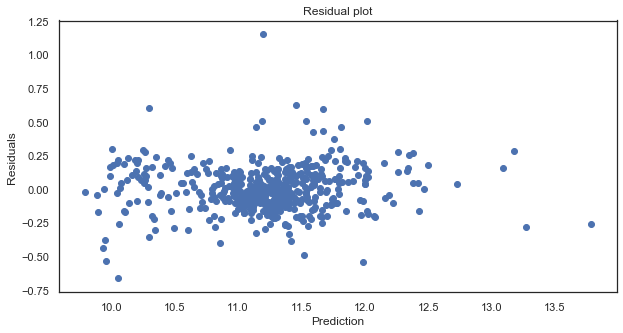

In [310]:
# Defining Graph size
plt.figure(figsize=(10,5))

# Defining the residue and model predicted results
df_categorized_car_brands['PREDICTIONS'] = results.predict(X_test)
df_categorized_car_brands['RESIDUE'] = y_test - model_test_pred

# Plot your predicted values on the x-axis, and your residuals on the y-axis on Residue Plot
plt.scatter(df_categorized_car_brands['PREDICTIONS'], df_categorized_car_brands['RESIDUE'])
plt.title("Residual plot")
plt.xlabel("Prediction")
plt.ylabel("Residuals")

## Section 6.2: QQ Plot

C:\Users\xianj\Anaconda3\envs\metis\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\xianj\Anaconda3\envs\metis\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\xianj\Anaconda3\envs\metis\lib\site-packages\scipy\stats\_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


Text(0.5, 1.0, 'Normal Q-Q plot')

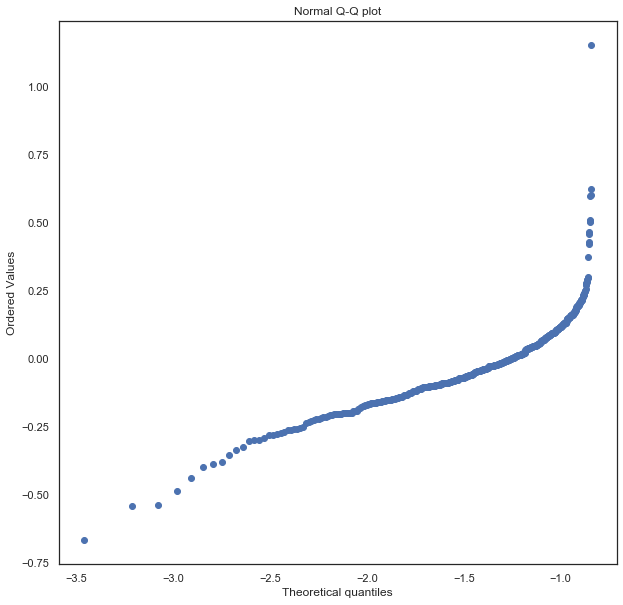

In [311]:
# Defining the residue and model predicted results
df_categorized_car_brands['PREDICTIONS'] = results.predict(X_test)
df_categorized_car_brands['RESIDUE'] = y_test - model_test_pred

# diagnose/inspect residual normality using QQplot:
plt.figure(figsize=(10,10))
stats.probplot(df_categorized_car_brands['RESIDUE'], dist="norm", plot=plt)
plt.title("Normal Q-Q plot")